In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
from itertools import product
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
plt.style.use('seaborn-v0_8-muted')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, accuracy_perumtations, 
    age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
    fit_deconfound_model, 
)

Fri Jul 14 13:41:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1A:00.0 Off |                  N/A |
| 27%   27C    P8     6W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
save_figures = False

In [4]:
# TODO: 
# mail denis
# mail joschka
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?

In [5]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [6]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-07T06:28:03.373666' # TCN exluding recs with age divergence, subject-wise cv
#exp = '2023-02-09T09:34:21.685021' # TCN exluding recs with age divergence, subject-wise fe 


#exp = '2023-02-10T23:14:51.938016'  # mixed patho and non-patho data
#exp = '2023-02-11T09:11:11.990975'  # subset non-patho, match patho and non-patho dists
#exp = '2023-02-11T09:11:23.883557'  # subset non-patho, uniform patho and non-patho dists

exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
#exp = '2023-05-04T08:38:44.048946'  # cv, l2loss
#exp = '2023-05-08T09:22:38.974401'  # fe, l2loss  # currently re-running with longitudinals
#exp = '2023-05-09T09:15:59.256046'  # fe, l2loss  # longitudinal crashed

#exp = '2023-02-22T12:51:02.928667'


exp_dir = os.path.join(base_dir, exp)

In [7]:
configs = read_result(exp_dir, 'config')

In [8]:
assert len(configs) == 5

In [9]:
configs.iloc[0]

augment                                                                dropout
batch_size                                                                 128
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
date                                                2023-02-15T18:43:26.819382
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   1
intuitive_training_scores                                                    1
loss                                                                       mae
max_age                                                                     -1
min_age                                                                     -1
model_name                                                                 tcn
n_epochs                                            

In [10]:
assert configs['final_eval'].nunique() == 1

In [11]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed', 'final_eval']]

,model_name,target_name,valid_set_i,seed,final_eval
0,tcn,age,0,20230214,1
0,tcn,age,0,20230215,1
0,tcn,age,0,20230216,1
0,tcn,age,0,20230217,1
0,tcn,age,0,20230218,1


In [12]:
scores = read_result(exp_dir, 'score')

In [13]:
def average_scores(scores):
    scores_ = {}
    for score in scores.index.unique():
        for subset in scores.columns:
            if subset not in scores_:
                scores_[subset] = {}
            scores_[subset].update({score: scores.loc[score, subset].mean()})
    return pd.DataFrame(scores_).drop(['seed', 'valid_set_i'], axis=1)

In [14]:
average_scores(scores)

,train,eval,eval_not_normal,transition,non_pathological,pathological,transition_long,non_pathological_long,pathological_long,transition_long_clean_age,non_pathological_long_clean_age,pathological_long_clean_age
mae,2.676739,6.517127,13.415539,11.770793,1.337067e+01,16.250088,11.697070,1.202639e+01,15.792732,12.120994,11.815610,15.638920
mape,0.065842,0.166104,0.232763,0.407534,2.108755e+06,587487.061264,0.407996,2.386170e+06,586644.279400,0.376190,0.559343,0.377315
mdae,1.742511,5.434862,11.378739,9.664617,9.604606e+00,13.560675,9.404413,8.497187e+00,13.093110,9.613568,9.237580,12.994081
mdape,0.042046,0.136944,0.201271,0.206327,2.239139e-01,0.252980,0.201404,2.034687e-01,0.244721,0.206254,0.215884,0.244187
r2,0.938632,0.729647,0.091834,0.301654,1.705781e-01,-0.077597,0.309442,2.445779e-01,-0.066213,0.230802,0.159408,-0.147724


In [15]:
histories = read_result(exp_dir, 'history')

In [16]:
loss = configs['loss'].unique()
assert len(loss) == 1
loss = loss[0]
if loss == 'mae':
    loss_label = 'L1 Loss' 
elif loss == 'mse':
    loss_label = 'L2 Loss'
else:
    raise NotImplementedError

In [17]:
fe = (configs['final_eval'] == '1').all()

In [18]:
cv_or_fe = 'fe' if fe else 'cv'

In [19]:
fe, cv_or_fe

(True, 'fe')

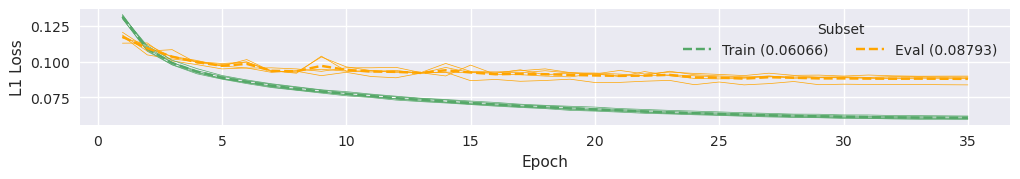

In [20]:
if fe:
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], loss_label, 'Eval')
    #ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_curves.png')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], loss_label)
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        #ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_curves_{n1}')

In [21]:
def prepare_preds(g1, sex, min_age, max_age):
    g1 = g1[g1.gender==sex] if sex is not None else g1
    max_age = g1.age.max() if max_age is None else max_age
    min_age = g1.age.min() if min_age is None else min_age
    g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
    # if fe, average over different seeds; if cv, basically don't average
    grouper = ['subset', 'index'] if fe else ['subset', 'subject', 'session', 'segment', 'seed']
    # after averaging, seed variable does not make sense anymore, so drop it
    g1 = g1.reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)#.drop(['seed'], axis=1)
    g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
    return g1


def add_deconfounded_predictions(g1, coefs):
    if coefs is None:
        coefs = fit_deconfound_model(
            g1[g1.pathological == False].y_true, 
            g1[g1.pathological == False].y_pred, 
        )
    g1['y_pred_confounded'] = g1.y_pred
    for kind, coef in coefs.items():
        #g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_true]  # y
        g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_pred]
    return g1, coefs


# from list of coeffs generate a string representing the function formula
def coefs_to_func_str(coefs):
    s = ''.join([f' + {coef:.2E}'+'x'*i if coef >= 0 else f'{coef:.2E}'+'x'*i for i, coef in enumerate(coefs[::-1])][::-1])
    if s.startswith('+'):
        s = s[2:]
    return 'f(x) = ' + s


# from list of coeffs compute the result of the represented function
def coefs_to_func(coefs, x):
    # coefs from high to low order
    return sum([coef*x**i for i, coef in enumerate(coefs[::-1])][::-1])


# plot bias of model that is being fit: ytrue to ypred-ytrue
def plot_true_age_vs_gap(y_true, y_pred, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.scatter(y_true, y_pred-y_true, facecolor='b', edgecolor='k', alpha=.5)
    ax.plot([0,100],[0,0], c='k', linewidth=1)
    ax.set_xlabel('Chronological Age [years]')
    ax.set_ylabel('Brain Age Gap\n[years]')
    ax.legend();
    ylim = np.max(np.abs(ax.get_ylim()))
    ax.set_ylim(-ylim, ylim)
    return ax


def plot_bias_model(coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    for (kind, coefs), style in zip(coeffs.items(), ['-', ':']):
        ax.plot(
            [coefs_to_func(coefs, p) for p in np.arange(100)], 
            label=coefs_to_func_str(coefs), linewidth=2,
            linestyle=style, c='cyan',
        )
    ax.legend(loc='lower left')
    return ax


def plot_model_bias(y_true, y_pred, coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax = plot_true_age_vs_gap(preds.y_true, preds.y_pred, ax=ax)
    ax = plot_bias_model(coeffs, ax)
    return ax

In [22]:
preds = read_result(exp_dir, 'preds')
preds.shape

(1215, 20)

In [23]:
age_limits = [(None, None)]# [(None, 30), (30, 60), (60, None)]  #[(None, 30), (30, 60), (60, None)]#
sexes = [None]#['F', 'M'] #[None]#

In [24]:
preds = prepare_preds(preds, sex=None, min_age=None, max_age=None)
preds.shape

(219, 17)

In [25]:
def accs_for_patho_from_thresh(series, pathological):
    assert len(series) == len(pathological)
    accs = []
    for i in range(len(series)):
        acc = balanced_accuracy_score(pathological, i*[0]+(len(series)-i)*[1])
        accs.append(acc*100)
    return accs


def plot_accs_for_patho_from_thresh(dataframe, accs, ax=None):
    df = dataframe.copy()
    df.pathological = df.pathological == 1
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 1.5))
    #ax2 = ax.twinx()
    #ax2 = sns.histplot(data=tmp, x='y_true', hue='pathological', ax=ax2, binwidth=1, palette={0: 'b', 1: 'r'})
    ax.plot(df.y_true, accs, c='k')
    #ax.plot(data=df, x='y_true', y=accs, c='k', ax=ax, errorbar=None)#, hue='pathological', palette={0: 'b', 1: 'r'}, alpha=.5)
    #ax.plot([0, 100], [50, 50], c='k', linestyle='--')
    #ax.axvline(tmp.y_true.iloc[np.array(accs).argmax()], c='cyan', linewidth=1)
    ax.set_ylabel('Balanced Accuracy\n[%]')
    return ax

In [26]:
from decode_tueg import plot_violin_new, accuracy_perumtations, get_hist_perm_test_grid

In [27]:
n_repetitions = 100

acc based on cv age thresh (48.25) 66.54%
acc based on fe age thresh (62.00) 67.13%
p=1.00E-02


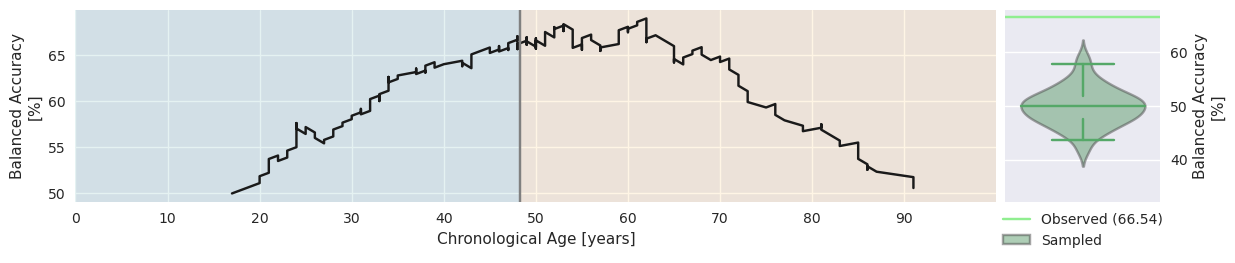

In [28]:
ax0, ax1 = get_hist_perm_test_grid()
accs = accs_for_patho_from_thresh(
    preds.sort_values('y_true').y_true,
    preds.sort_values('y_true').pathological,
)
ax = plot_accs_for_patho_from_thresh(
    preds.sort_values('y_true'),
    accs,
    ax0,
)
ax.set_xlim([0, 100])
if not fe:
    thresh = preds.sort_values('y_true').y_true.iloc[np.argmax(accs)]
    #thresh = 48.25000096857548
    #print(f'cv age thresh {thresh:.2f}')
    acc = 100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)
    print(f'acc based on cv age thresh ({thresh:.2f}) {acc:.2f}%')    
else:
    thresh = 48.25000096857548
    acc = 100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)
    print(f'acc based on cv age thresh ({thresh:.2f}) {acc:.2f}%')    
    optimal_thresh = preds.sort_values('y_true').y_true.iloc[np.argmax(accs)]
    print(f'acc based on fe age thresh ({optimal_thresh:.2f}) {(100*balanced_accuracy_score(preds.pathological, preds.y_true > optimal_thresh)):.2f}%')    
    #print(f'acc based on cv age thresh {(100*balanced_accuracy_score(preds.pathological, preds.y_true > thresh)):.2f}%')
ax.axvline(thresh, c='grey')
ax.set_xlabel('Chronological Age [years]')

ax.axvspan(0, thresh, facecolor='teal', alpha=.1)
ax.axvspan(thresh, 100, facecolor='orange', alpha=.1)

observed, sampled = accuracy_perumtations(
    preds,
    n_repetitions=n_repetitions,
    indicator='age',
)
plot_violin_new(
    acc,
    sampled,
    50,
    ax1,
)
ax1.set_ylabel('Balanced Accuracy\n[%]')

ticks = np.linspace(0,100,11,dtype=int)[:-1]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

#ax.axvline(preds[preds.pathological==1].y_true.mean(), c='magenta')
#ax.axvline(preds[preds.pathological==0].y_true.mean(), c='teal')
#ax.legend(title='Pathological')
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_thresh')

In [29]:
preds

,subset,pathological,subject,index,y_true,y_pred,year,month,day,session,segment,train,age,date_age,report_age,seed,valid_set_i
0,eval,0.0,21.0,96.0,35.000000,36.608768,2013.0,8.0,15.0,4.0,0.0,1.0,35.0,35.0,34.0,20230216.0,0.0
1,eval,0.0,436.0,76.0,59.999998,65.605436,2013.0,7.0,31.0,2.0,1.0,1.0,60.0,60.0,60.0,20230216.0,0.0
2,eval,0.0,2355.0,32.0,65.999999,64.465969,2013.0,6.0,28.0,2.0,1.0,1.0,66.0,66.0,65.0,20230216.0,0.0
3,eval,0.0,3211.0,83.0,70.000002,60.083268,2013.0,8.0,7.0,2.0,0.0,1.0,70.0,70.0,69.0,20230216.0,0.0
4,eval,0.0,3240.0,135.0,55.000001,42.460030,2013.0,10.0,10.0,2.0,1.0,1.0,55.0,55.0,55.0,20230216.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,eval_rest,1.0,10743.0,95.5,24.000000,57.988385,2013.0,9.0,21.0,1.5,0.0,1.0,24.0,24.0,24.0,20230216.0,0.0
215,eval_rest,1.0,10767.0,95.0,87.000000,61.145750,2013.0,9.0,19.0,1.0,0.0,1.0,87.0,87.0,87.0,20230216.0,0.0
216,eval_rest,1.0,10775.0,98.0,86.000001,65.754040,2013.0,9.0,27.0,1.0,0.0,1.0,86.0,86.0,86.0,20230216.0,0.0
217,eval_rest,1.0,10782.0,102.0,85.000002,43.926014,2013.0,10.0,4.5,1.5,1.0,0.0,85.0,85.0,84.0,20230216.0,0.0


In [38]:
preds['gap'] = preds.y_pred - preds.y_true
accs = accs_for_patho_from_thresh(
    preds.sort_values('gap').gap,
    preds.sort_values('gap').pathological,
)

In [40]:
ax = plot_accs_for_patho_from_thresh(
    preds.sort_values('gap').gap,
    accs,
)
thresh = preds.sort_values('gap').gap.iloc[np.argmax(np.abs([100-a for a in accs]))]
ax.axvline(thresh, c='grey')
ax.set_xlabel('Decoded Age – Chronological Age [years]')

AttributeError: 'Series' object has no attribute 'pathological'

In [41]:
# exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
# exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
cv_exp_dir = '/home/jovyan/experiments/2023-02-15T18:59:11.767923'
cv_seed = '20230214'

In [42]:
if not fe:
    assert configs.seed.nunique() == 1
    cv_seed = configs.seed.unique()[0]
    cv_exp_dir = exp_dir
cv_dir = os.path.join(cv_exp_dir, cv_seed)

In [43]:
# if cv_dir is None
fn = 'bias_models.json'
if not fe:
    preds, coeffs = add_deconfounded_predictions(preds, coefs=None)
    p = os.path.join(cv_dir, fn)
    print(f"duming model coefficients to {p}")
    json.dump(coeffs, open(p, 'w'))
else:
    p = os.path.join(cv_dir, fn)
    print(f"loading model coefficients from {p}")
    coeffs = json.load(open(p, 'r'))
    preds, coeffs = add_deconfounded_predictions(preds, coefs=coeffs)
coeffs

loading model coefficients from /home/jovyan/experiments/2023-02-15T18:59:11.767923/20230214/bias_models.json


{'linear': [-0.36310181197536046, 15.374280445171014],
 'quadratic': [-0.004431773520303435, 0.05752921309654997, 6.582235069495847]}

In [44]:
def plot_biased_vs_corrected_gap_to_age_with_dists(y_true, y_pred, y_pred_deconfounded, coeffs, age_hist=True, binwidth=1):
    fig, ax_arr = plt.subplots(3, 2, figsize=(12,5), width_ratios=[.9, .1])
    fig.subplots_adjust(hspace=.1)
    fig.subplots_adjust(wspace=.025)

    if not age_hist:
        ax = ax_arr[0,1]
        ax.remove()

    ax = ax_arr[1,0]
    ax = plot_model_bias(
        y_true, 
        y_pred,
        coeffs,
        ax=ax,
    )
    ax.set_xlabel('')
    ax.set_xticklabels([])
    lims = ax.get_ylim()

    ax = ax_arr[1,1]
    sns.histplot(y=y_pred-y_true, ax=ax, binwidth=binwidth, kde=True)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.yaxis.tick_right()
    #ax.set_ylim([0,100])
    ax.set_ylabel("")
    ax.set_ylim(lims)

    ax = ax_arr[2,0]
    ax = plot_true_age_vs_gap(y_true, y_pred_deconfounded, ax=ax)
    ax.set_ylabel('Corrected\nBrain Age Gap\n[years]');
    ticks = ax.get_xticks()
    lim = ax.get_xlim()
    lims = ax.get_ylim()

    ax = ax_arr[2,1]
    sns.histplot(y=y_pred_deconfounded-y_true, ax=ax, binwidth=binwidth, kde=True)
    ax.yaxis.tick_right()
    #ax.set_ylim([0,100])
    ax.set_ylabel("")
    ax.set_ylim(lims)

    if age_hist:
        ax = ax_arr[0,0]
        sns.histplot(y_true, ax=ax, binwidth=binwidth, kde=True)
        ax.set_xlabel('')
        ax.set_xticklabels([]);
        ax.set_xticks(ticks)
        ax.set_xlim(lim)
    else:
        ax = ax_arr[0,0]
        ax.remove()
    return ax_arr

In [45]:
def plot_biased_vs_corrected_gap_to_age(y_true, y_pred, y_pred_deconfounded, coeffs):
    fig, ax_arr = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    fig.subplots_adjust(hspace=.1)
    ax = plot_model_bias(
        y_true, 
        y_pred,
        coeffs,
        ax=ax_arr[0],
    )
    ax.set_xlabel('')
    ax = plot_true_age_vs_gap(y_true, y_pred_deconfounded, ax=ax_arr[1])
    ax.set_ylabel('Corrected\nBrain Age Gap\n[years]');
    return ax

In [46]:
fit_deconfound_model(preds[preds.pathological==0].y_true, preds[preds.pathological==0].y_pred)

{'linear': (-0.3290777344963141, 13.598413676371154),
 'quadratic': (-0.0017585743367344745,
  -0.16745359881063412,
  10.335490810065528)}

In [47]:
detrend = 'quadratic'

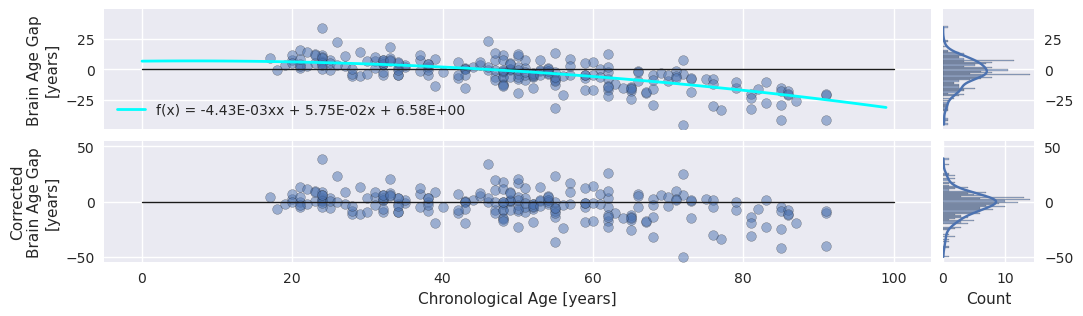

In [48]:
# plot_biased_vs_corrected_gap_to_age(preds.y_true, preds.y_pred, preds.y_pred_deconfounded_quadratic, coeffs)
ax_arr = plot_biased_vs_corrected_gap_to_age_with_dists(
    preds.y_true, preds.y_pred, 
    preds[f'y_pred_deconfounded_{detrend}'], {detrend: coeffs[detrend]}, 
    age_hist=False)
if save_figures:
    save_fig(ax_arr[-1,-1].get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_bias_model')

In [49]:
preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}']

In [50]:
from decode_tueg import find_threshs

In [51]:
fn = 'proxy_thresholds.json'
if not fe:
    (t_low, t_high) = find_threshs(preds)
    threshs = {'t_low': t_low, 't_high': t_high}
    p = os.path.join(cv_dir, fn)
    print(f"duming thresholds to {p}")
    json.dump(threshs, open(p, 'w'))
else:
    p = os.path.join(cv_dir, fn)
    print(f"loading thresholds from {p}")
    threshs = json.load(open(p, 'r'))
    t_low = threshs['t_low']
    t_high = threshs['t_high']  
t_low, t_high

loading thresholds from /home/jovyan/experiments/2023-02-15T18:59:11.767923/20230214/proxy_thresholds.json


(-9.219088895674346, 8.589625318405407)

In [52]:
bin_width = 2
n_repetitions = 100

In [53]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [54]:
from decode_tueg import plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test

In [55]:
mean_absolute_error(preds[preds.pathological==0].y_true, preds[preds.pathological==0].y_pred_confounded)

6.475429911260951

In [56]:
mean_absolute_error(preds[preds.pathological==0].y_true, preds[preds.pathological==0].y_pred_deconfounded_linear)

6.715772451107209

In [57]:
mean_absolute_error(preds[preds.pathological==0].y_true, preds[preds.pathological==0].y_pred_deconfounded_quadratic)

6.60445472036638

In [58]:
save_figures = False

p=3.00E-02
p=1.60E-01


"\nax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(\n    preds, t_low, t_high, bin_width, n_repetitions,\n)\nif save_figures:\n    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_hist_and_proxy')\n"

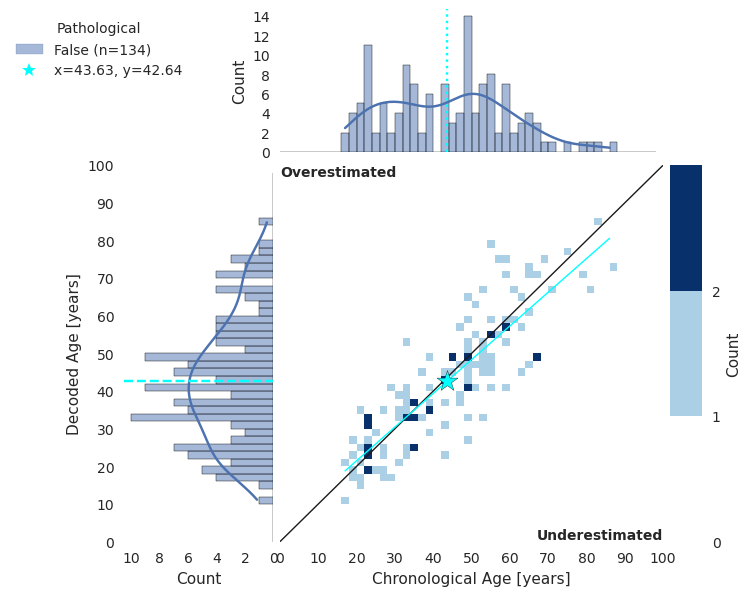

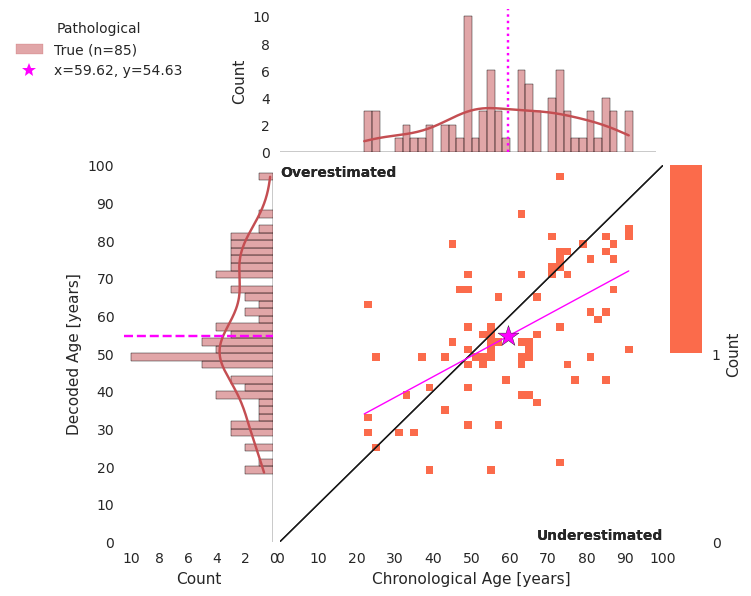

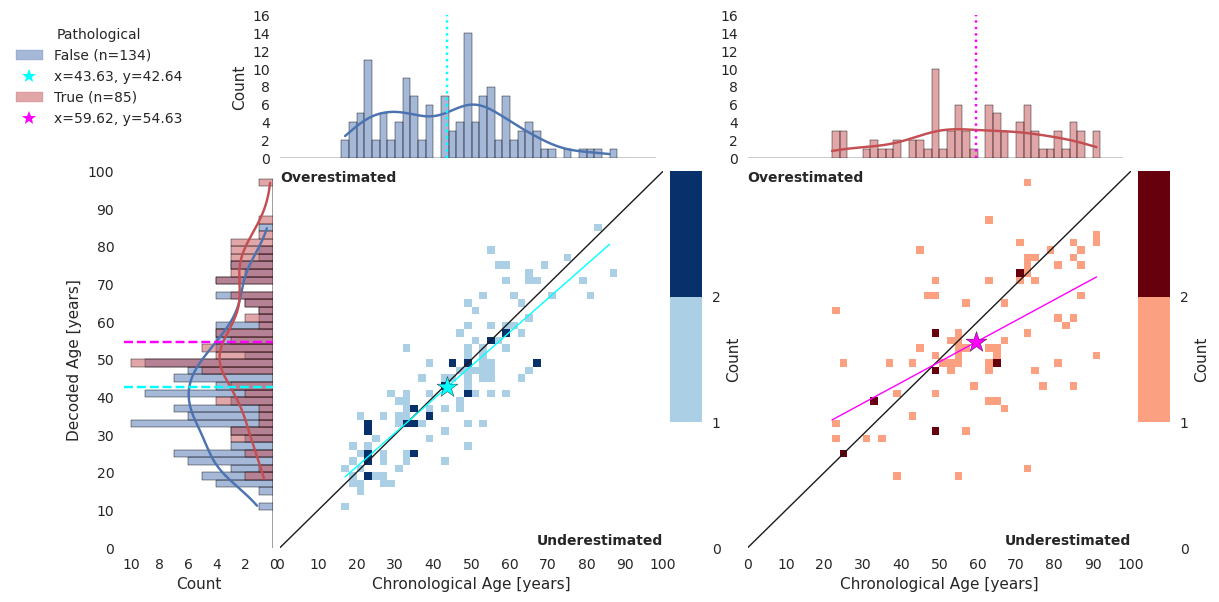

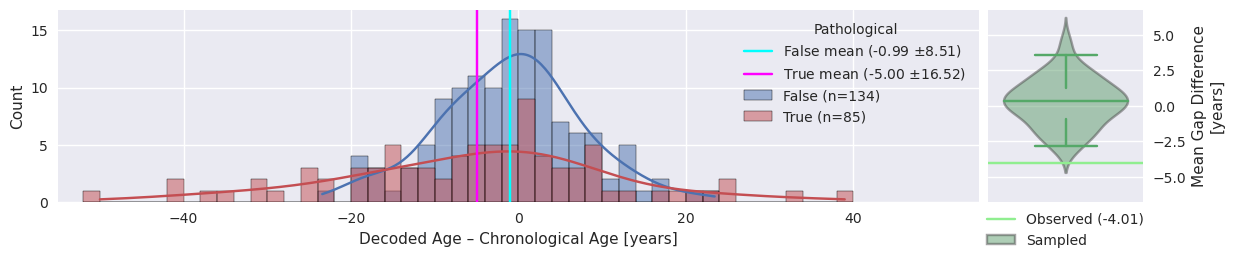

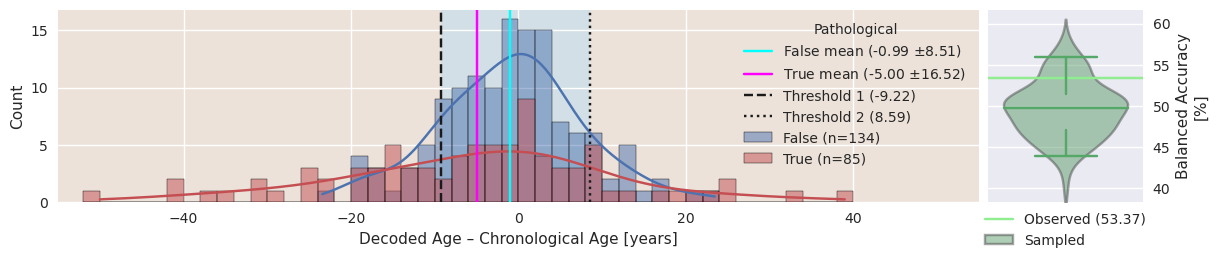

In [50]:
#preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}'] if not fe else preds['y_pred_confounded']
#preds['y_pred'] = preds[f'y_pred_confounded']
ax = plot_heatmaps(preds[preds.pathological==0], bin_width)
save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_np_age_heatmap')
ax = plot_heatmaps(preds[preds.pathological==1], bin_width)
save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_p_age_heatmap')
ax = plot_heatmaps(preds, bin_width)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_heatmap')
preds['y_pred'] = preds[f'y_pred_deconfounded_{detrend}']
ax = plot_age_gap_hist_and_permutation_test(preds, bin_width, n_repetitions)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_histogram')
ax = plot_age_gap_hist_with_thresh_and_permutation_test(
    preds, t_low, t_high, bin_width, n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_proxy')
"""
ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
    preds, t_low, t_high, bin_width, n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'{cv_or_fe}_age_gap_hist_and_proxy')
"""

# FE analysis

In [59]:
import re

import mne

from decode_tueg import (
    deconfound, plot_age_gap_hist_and_permutation_test, 
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test,
    mean_abs_running_diff_of_mean_corrected_gaps, _reject_derivating_ages,
    plot_mean_abs_running_diff_of_mean_corrected_gaps,
)

In [60]:
def get_longitudinal_preds(ds_name, min_mins=None, clean_age=False):
    preds = read_result(exp_dir, f'longitudinal_{ds_name}')
    preds['path'] = [p.replace('/data/datasets/TUH/EEG/', '/home/jovyan/mne_data/TUH/') for p in preds.path]
    #preds.shape, preds.subject.nunique()

    if clean_age:
        #assert min_mins is not None
        gs = []
        for p, g in preds.groupby('path'):
            raw = mne.io.read_raw_edf(p, verbose='error')
            rec_year = raw.info['meas_date'].year
            # seems like one (?) header broke in preprocessing. read header of original unpreprocessed reocrding
            header = TUHAbnormal._read_edf_header(p)
            pattern = r'\d\d-\w\w\w-(\d\d\d\d)'
            matches = re.findall(pattern, str(header))
            if len(matches) != 1:
                birthyear = np.nan
            else:
                birthyear = int(matches[0])
            g['date_age'] = int(rec_year) - birthyear

            pattern = r'(\d+)[ -]+?[years]{3,5}[ -]+?[old]{3}'
            # is this also fine? also finds 33 y.o. often used in old reports
            #pattern = r'(\d+)[ -]+?[years]{1,5}[ -.]+?[old]{1,3}[ .]+?'  
            matches = re.findall(pattern, g.iloc[0].report)
            if len(matches) >= 1:
                # assume report always starts with 'XX year old ...'
                match = int(matches[0])
            elif len(matches) == 0:
                match = np.nan
            g['report_age'] = match
            gs.append(g)
        gs = pd.concat(gs).reset_index()
        gs.shape, gs.subject.nunique()

        preds = gs

        ids = _reject_derivating_ages(preds)
        preds = preds.iloc[ids]
        preds = preds.set_index('index')
        preds.shape, preds.subject.nunique()

    gs = []
    for seed, group in preds.groupby('seed'):
        group['duration'] = group.n_samples / group.sfreq
        if min_mins is not None:
            group = group[group.duration >= min_mins*60]
        # for eacht subject, there have to be at least two recs still after min duration selection
        for subject, g in group.groupby('subject'):
            if len(g) >= 2:
                # if this is transition, we require both pathologies
                if 'transition' in ds_name and g.pathological.nunique() != 2:
                    continue
                gs.append(g)
    gs = pd.concat(gs)
    return gs

In [61]:
def get_01_10_transitions(preds):
    gs_01, gs_10 = [], []
    for n, g in preds.groupby('subject'):
        #if len(g) == 2:
        if g.pathological.diff().sum() > 0:
            gs_10.append(g)
        elif g.pathological.diff().sum() < 0:
                gs_01.append(g)
        else:
            assert g.pathological.diff().sum() == 0
            #print(n)
    if gs_01:
        gs_01 = pd.concat(gs_01)
    if gs_10:
        gs_10 = pd.concat(gs_10)
    return gs_01, gs_10

In [62]:
def counts(preds):
    rec_preds = preds.copy()
    print(f'{len(rec_preds)} recs of {rec_preds.subject.nunique()} subjects')
    # TODO: don't use seed here
    for seed, group in rec_preds.groupby('seed'):
        break
    print(f'per seed {len(group)} recs of {group.subject.nunique()} subjects')
    print(f"thereof female {group.groupby('subject').head(1).gender.value_counts()}")

In [63]:
ds_names = ['non_pathological', 'pathological', 'transition']
min_mins = 15
clean_age = True

In [64]:
reload = False
# these are predictions of five repetitions of fe
if reload:
    all_rec_preds = {ds_name: get_longitudinal_preds(ds_name, min_mins, clean_age) for ds_name in ds_names}
else:
    with open(f'/home/jovyan/long_{min_mins}_{clean_age}.pkl', 'rb') as f:
        all_rec_preds = pickle.load(f)

In [65]:
# map gender from M, F to 0, 1
all_rec_preds = {ds_name: rec_preds.replace({'M': 0, 'F': 1}) for ds_name, rec_preds in all_rec_preds.items()}

In [66]:
for ds_name in ds_names:
    print(ds_name)
    counts(all_rec_preds[ds_name])
    print()

non_pathological
1775 recs of 149 subjects
per seed 355 recs of 149 subjects
thereof female 1    88
0    61
Name: gender, dtype: int64

pathological
13395 recs of 1046 subjects
per seed 2679 recs of 1046 subjects
thereof female 1    530
0    516
Name: gender, dtype: int64

transition
2800 recs of 221 subjects
per seed 560 recs of 221 subjects
thereof female 1    119
0    102
Name: gender, dtype: int64



In [67]:
# average predictions over five runs of fe
grouper = ['subset', 'index']
all_rec_preds = {
    ds_name: all_rec_preds[ds_name].reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)
    for ds_name in ds_names
}

In [68]:
for ds_name in ds_names:
    print(ds_name)
    counts(all_rec_preds[ds_name])
    print()

non_pathological
355 recs of 149 subjects
per seed 355 recs of 149 subjects
thereof female 1.0    88
0.0    61
Name: gender, dtype: int64

pathological
2679 recs of 1046 subjects
per seed 2679 recs of 1046 subjects
thereof female 1.0    530
0.0    516
Name: gender, dtype: int64

transition
560 recs of 221 subjects
per seed 560 recs of 221 subjects
thereof female 1.0    119
0.0    102
Name: gender, dtype: int64



In [69]:
from decode_tueg import age_pyramid

In [70]:
save_figures = False

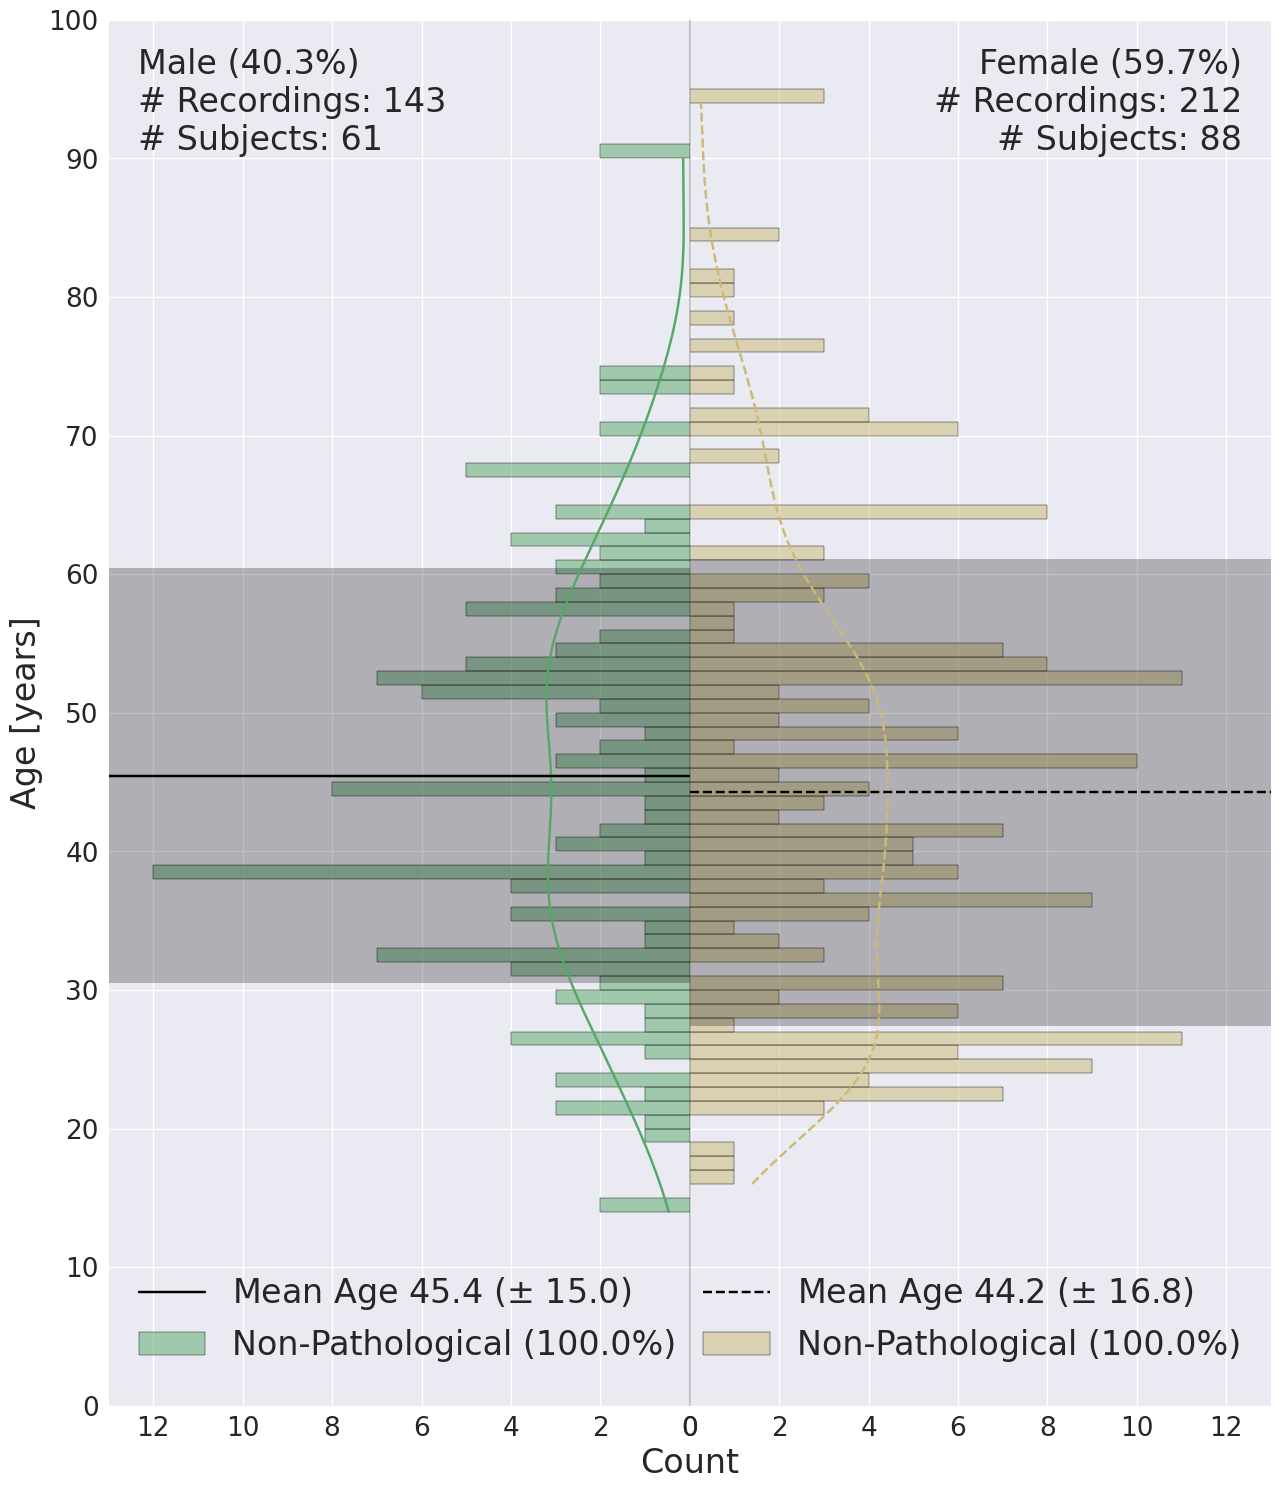

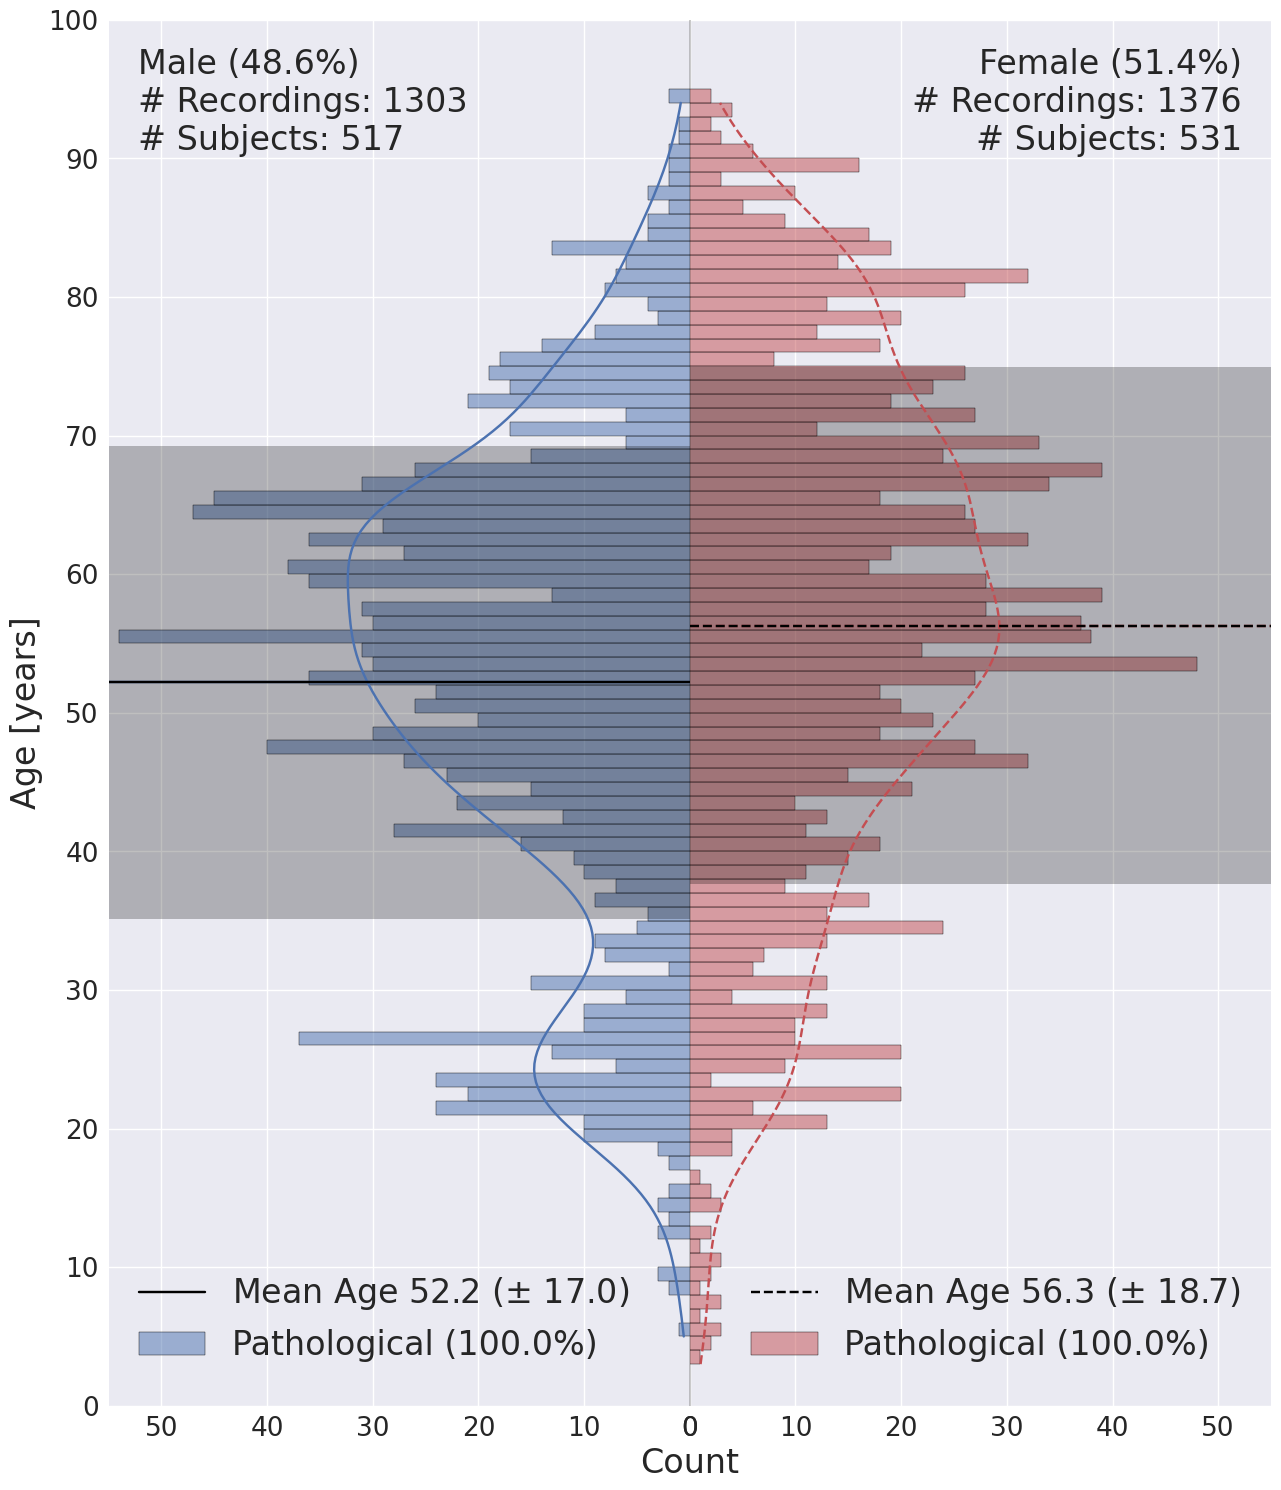

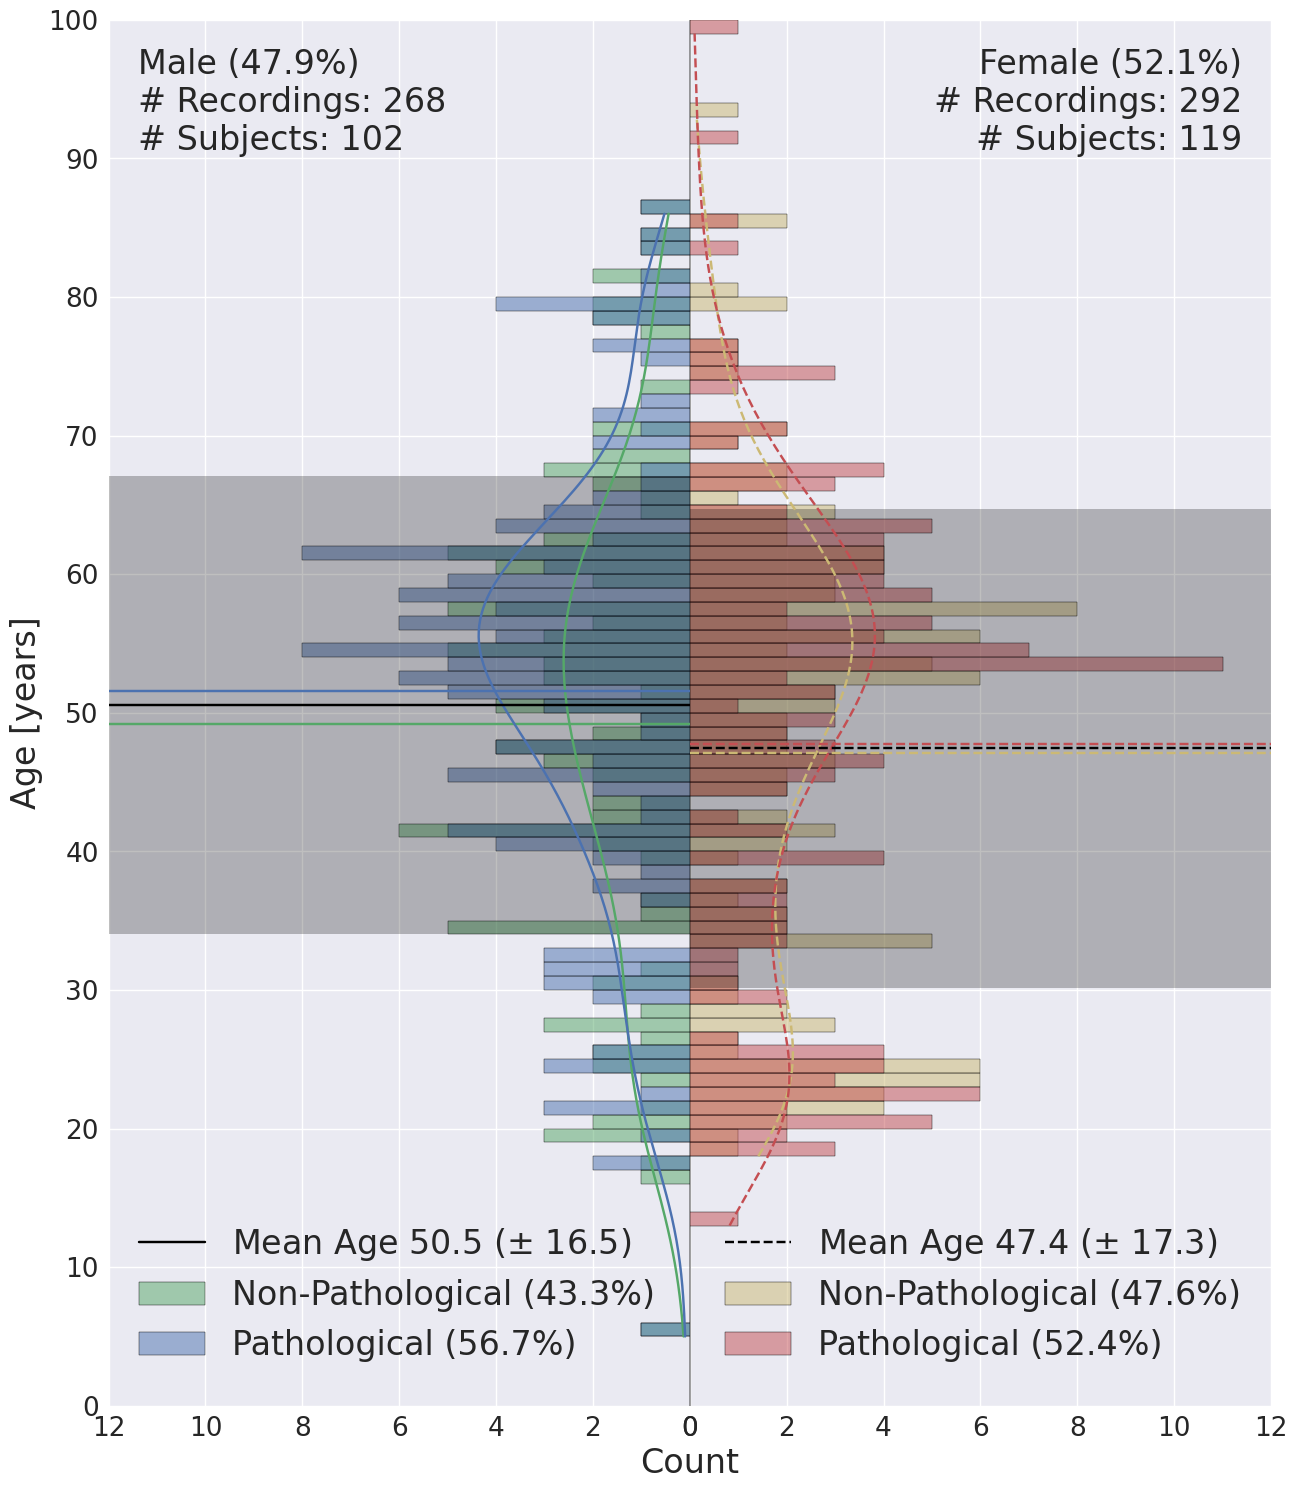

In [71]:
ylims = {'non_pathological': 13, 'pathological': 55, 'transition': 12}
for ds_name, rec_preds in all_rec_preds.items():
    ax_arr = age_pyramid(rec_preds, f'eval_{ds_name}', ylim=ylims[ds_name], show_title=False)
    if save_figures:
        save_fig(ax_arr[0].get_figure(), '/home/jovyan/figures/', f'{ds_name}_age_pyramid')

# deconfound predictions

In [72]:
all_rec_preds = {
    ds_name: add_deconfounded_predictions(rec_preds, coeffs)[0]
    for ds_name, rec_preds in all_rec_preds.items()
}

In [73]:
coeffs

{'linear': [-0.36310181197536046, 15.374280445171014],
 'quadratic': [-0.004431773520303435, 0.05752921309654997, 6.582235069495847]}

In [74]:
# average over seeds / runs, subject, subset, and pathology status
all_subj_preds = {
    ds_name: rec_preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    for ds_name, rec_preds in all_rec_preds.items()
}

In [75]:
for ds_name in ds_names:
    print(ds_name)
    counts(all_subj_preds[ds_name])
    print()

non_pathological
149 recs of 149 subjects
per seed 149 recs of 149 subjects
thereof female 1.0    88
0.0    61
Name: gender, dtype: int64

pathological
1046 recs of 1046 subjects
per seed 1046 recs of 1046 subjects
thereof female 1.0    529
0.0    515
0.5      2
Name: gender, dtype: int64

transition
442 recs of 221 subjects
per seed 442 recs of 221 subjects
thereof female 1.0    119
0.0    102
Name: gender, dtype: int64



In [76]:
# TODO: simply count increase in gap for non-patho, patho, pnp and npp?

In [77]:
bin_size = 2
n_repetitions = 100
#detrend = True
#thresh1 = -8.786315726356626 
#thresh2 = 4.877341101987973 
#thresh1 = -7.186685473771377
#thresh2 = 5.955300372252786

In [78]:
# for everything that follows, use deconfounded predictions
for ds_name in all_rec_preds.keys():
    all_rec_preds[ds_name]['y_pred'] = all_rec_preds[ds_name]['y_pred_deconfounded_quadratic']
for ds_name in all_subj_preds.keys():
    all_subj_preds[ds_name]['y_pred'] = all_subj_preds[ds_name]['y_pred_deconfounded_quadratic']

In [79]:
save_figures = False

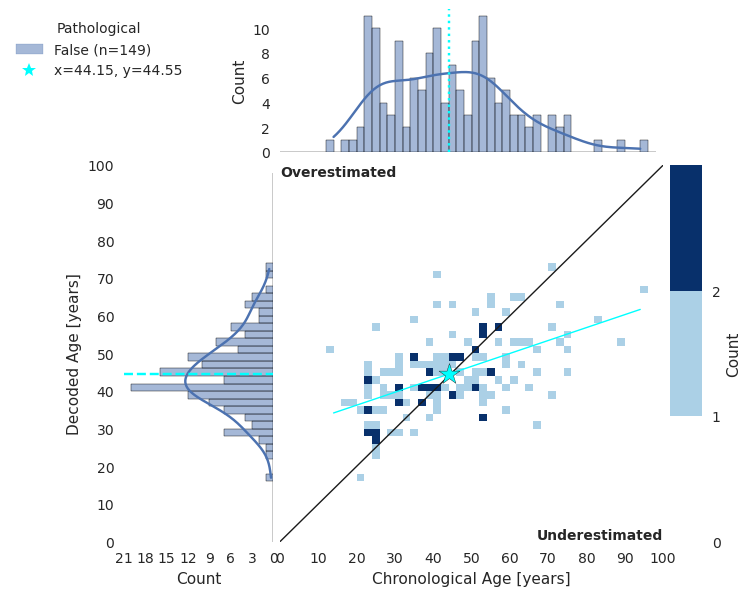

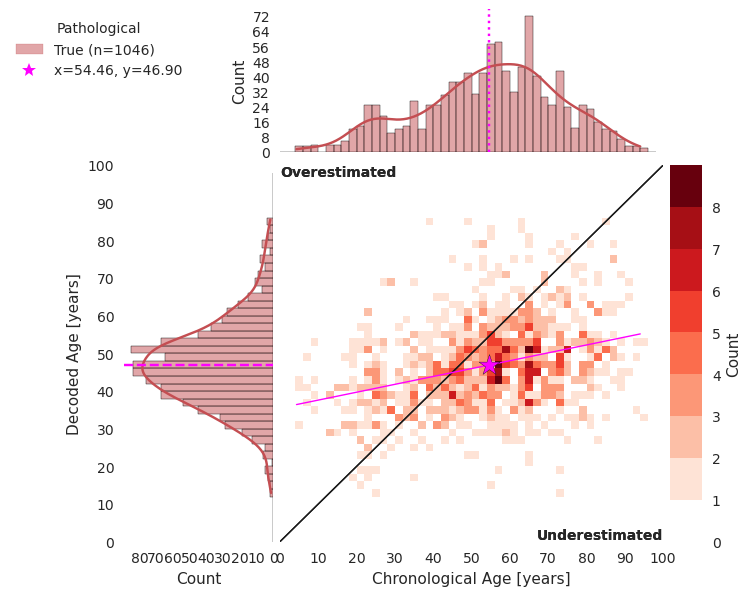

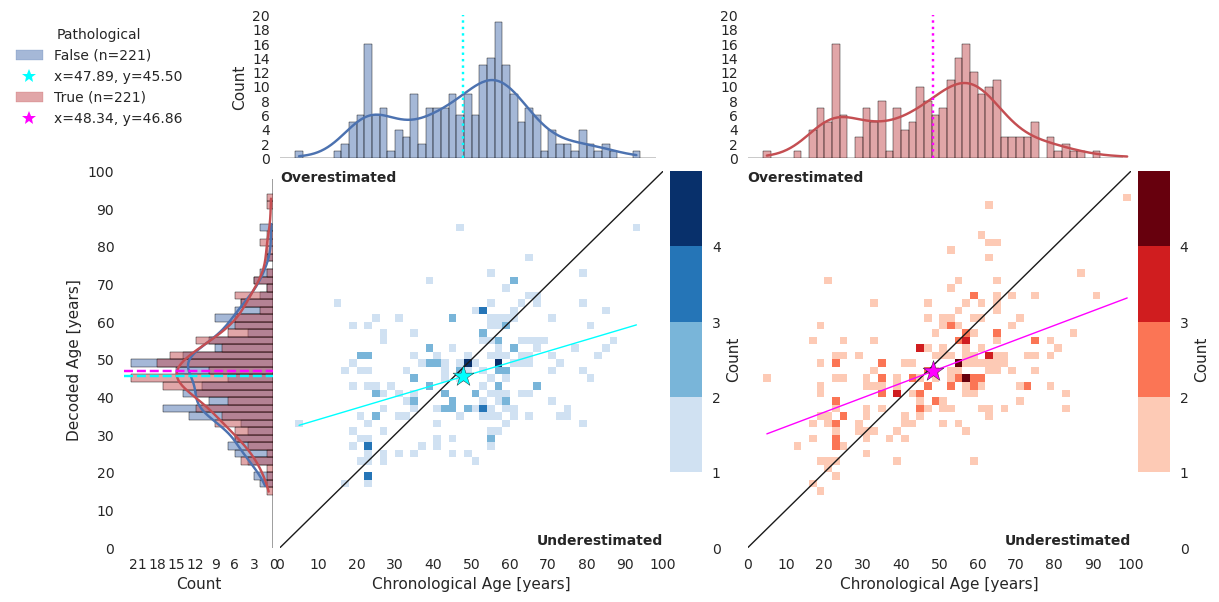

In [80]:
for ds_name, subj_preds in all_subj_preds.items():
    ax = plot_heatmaps(subj_preds, bin_size)
    if save_figures:
        save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_heatmap')

# all transitions

non_pathological
pathological
transition
p=4.80E-01
p=6.00E-02
p=5.20E-01


"\n    else:\n        ax = plot_age_gap_hist(subj_preds, bin_size)\n        if save_figures:\n            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_histogram')\n        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(\n            mean_abs_running_diff_of_mean_corrected_gaps(rec_preds),\n        )\n        if save_figures:\n            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_running_age_gap')\n"

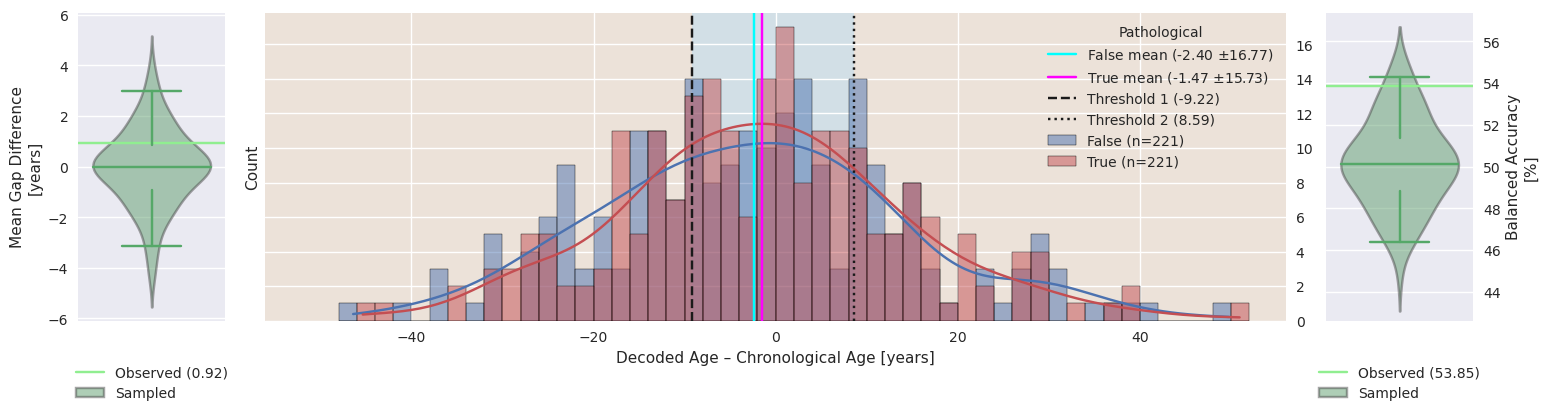

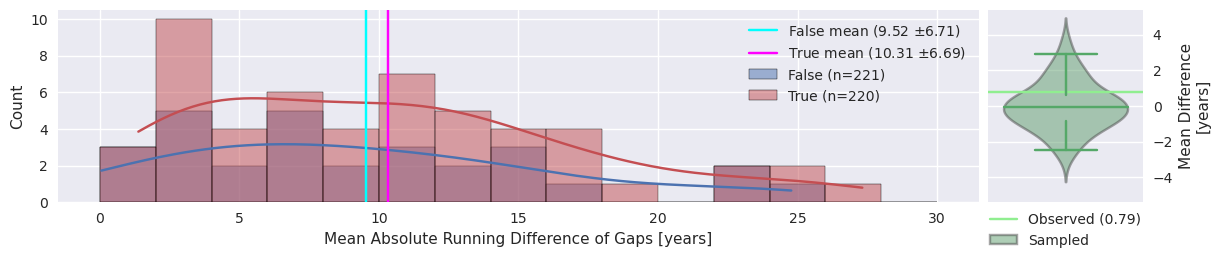

In [81]:
for ds_name in all_subj_preds.keys():
    rec_preds = all_rec_preds[ds_name]
    subj_preds = all_subj_preds[ds_name]
    print(ds_name)
    if ds_name.startswith('transition'):
        """
        ax = plot_age_gap_hist_and_permutation_test(subj_preds, bin_size, n_repetitions)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_histogram')
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            subj_preds,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_proxy')
        """
        ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
            subj_preds,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lt_age_gap_proxy')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
            mean_abs_running_diff_of_mean_corrected_gaps(rec_preds), 
            n_repetitions,
            bin_width,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_running_age_gap')
"""
    else:
        ax = plot_age_gap_hist(subj_preds, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_age_gap_histogram')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(
            mean_abs_running_diff_of_mean_corrected_gaps(rec_preds),
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_{ds_name}_running_age_gap')
"""

In [82]:
# compare LNP and LP datasets with permutation test

In [83]:
n_repetitions = 100
save_figures = False

p=1.00E-02
p=3.30E-01
p=1.00E-02


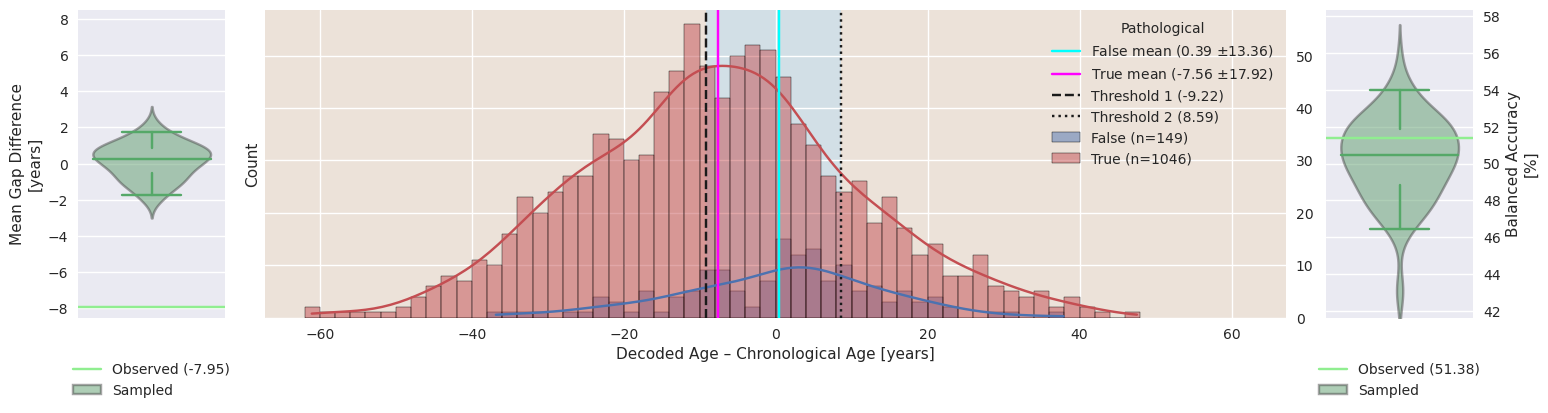

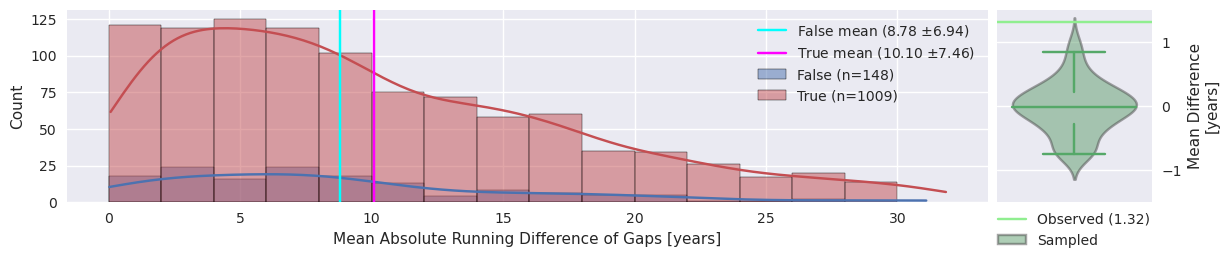

In [84]:
# compare LNP and LP datasets with permutation test
lnp_lp_subj_preds = pd.concat([all_subj_preds['non_pathological'], all_subj_preds['pathological']])
"""
ax = plot_age_gap_hist_and_permutation_test(lnp_lp_subj_preds, bin_size, n_repetitions)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lnp_lp_age_gap_comparison')
"""
ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
    lnp_lp_subj_preds,
    t_low,
    t_high,
    bin_size,
    n_repetitions,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lt_age_gap_proxy')
lnp_lp_rec_preds = pd.concat([all_rec_preds['non_pathological'], all_rec_preds['pathological']])
ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
    mean_abs_running_diff_of_mean_corrected_gaps(lnp_lp_rec_preds), 
    n_repetitions,
    bin_width,
)
if save_figures:
    save_fig(ax.get_figure(), '/home/jovyan/figures/', f'lnp_lp_running_gap_comparison')

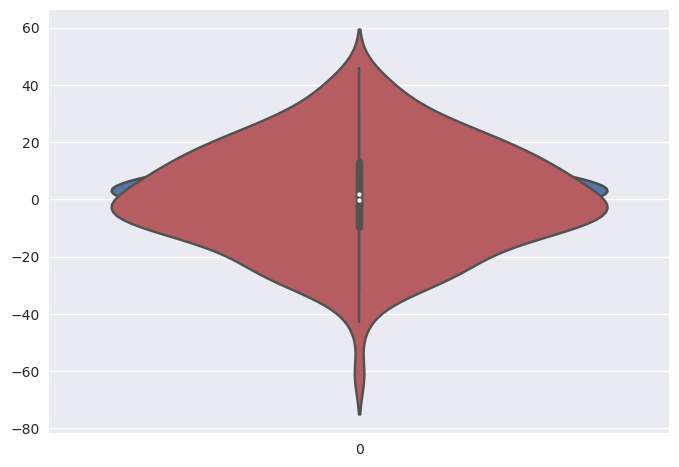

In [85]:
ax = sns.violinplot(
    all_subj_preds['non_pathological'].y_pred_deconfounded_quadratic - all_subj_preds['non_pathological'].y_true, color='b'
)
ax = sns.violinplot(
    all_subj_preds['pathological'].y_pred_deconfounded_quadratic - all_subj_preds['non_pathological'].y_true, color='r'
)

In [90]:
bin_size = 2
n_repetitions = 100000
save_figures = True

237 recs of 98 subjects
per seed 237 recs of 98 subjects
thereof female 1.0    56
0.0    42
Name: gender, dtype: int64

240 recs of 100 subjects
per seed 240 recs of 100 subjects
thereof female 1.0    52
0.0    48
Name: gender, dtype: int64


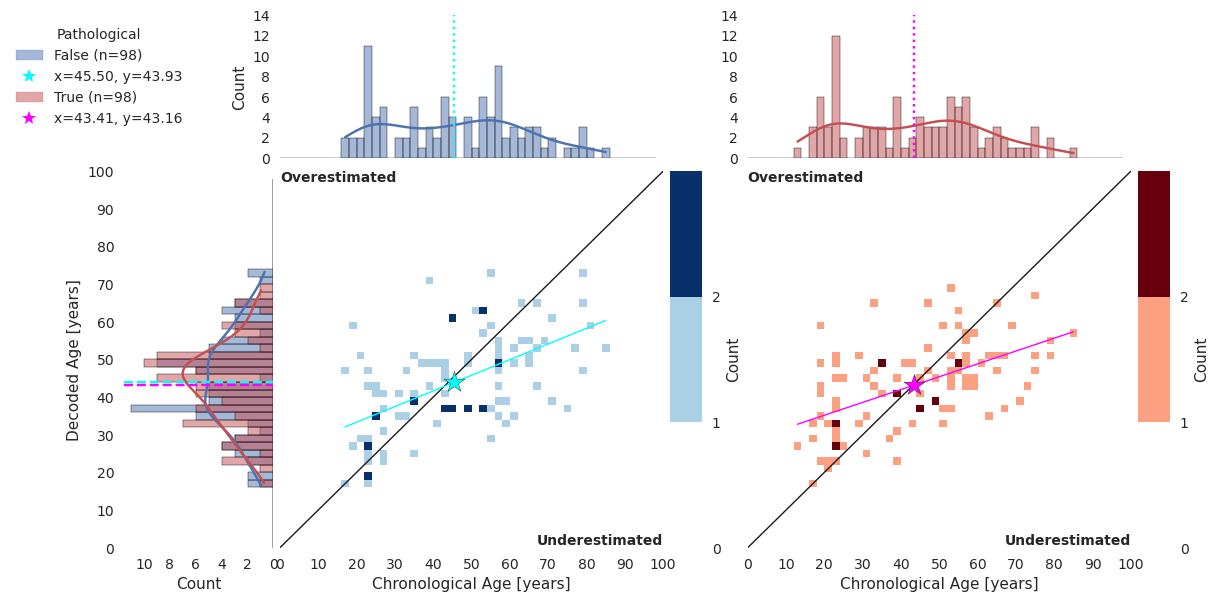

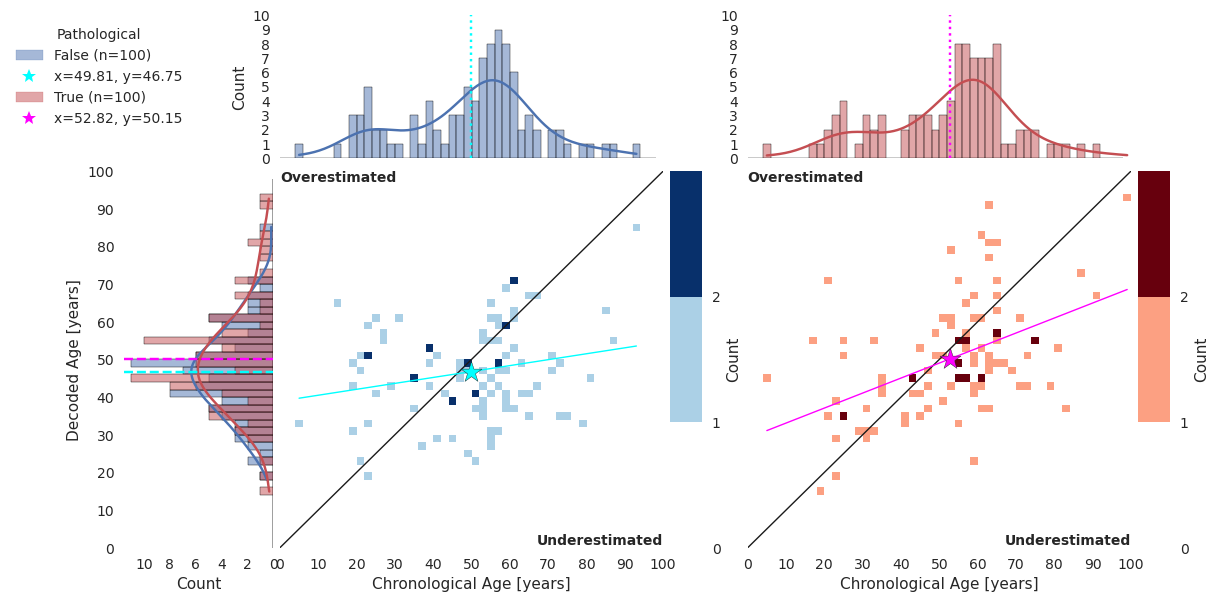

In [91]:
for ds_name, rec_preds in all_rec_preds.items():
    if ds_name.startswith('transition'):
        gs_01, gs_10 = get_01_10_transitions(rec_preds)
        counts(gs_01)
        print()
        counts(gs_10)

        # average over runs / seeds
        gs_01_subj = gs_01.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)
        gs_10_subj = gs_10.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)

        #plot_heatmaps(gs_01, bin_size)
        ax = plot_heatmaps(gs_01_subj, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_age_heatmap')
        #plot_heatmaps(gs_10, bin_size)
        ax = plot_heatmaps(gs_10_subj, bin_size)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_age_heatmap')

# 01 transitions

non_pathological
pathological
transition
p=5.38E-01
p=1.40E-01
p=4.18E-01


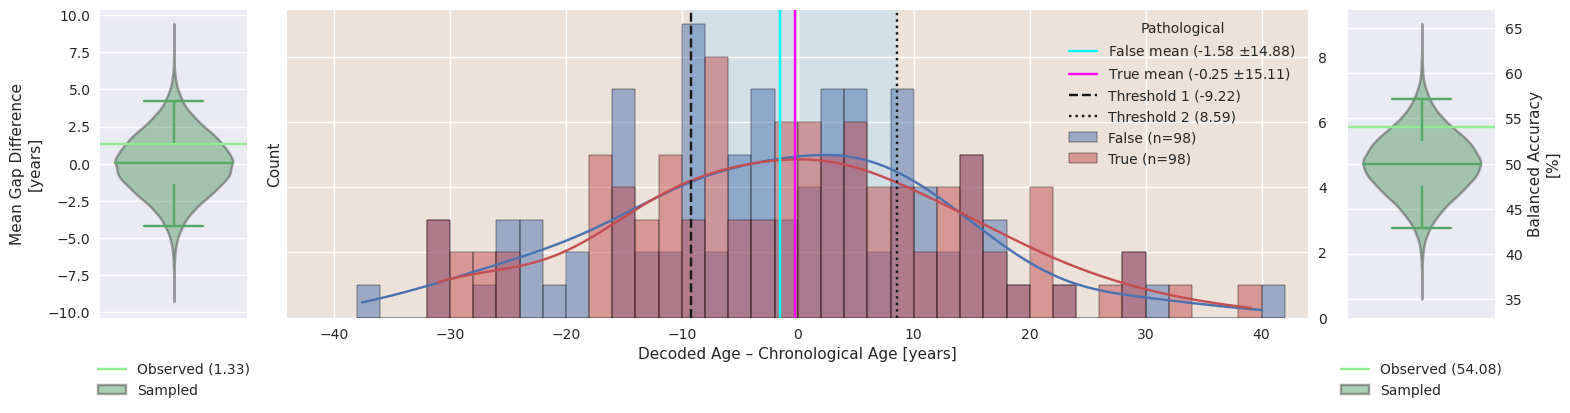

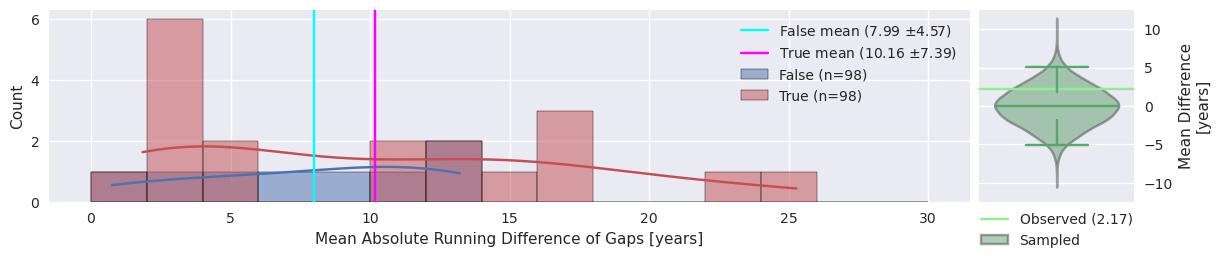

In [92]:
for ds_name in all_subj_preds.keys():
    rec_preds = all_rec_preds[ds_name]
    subj_preds = all_subj_preds[ds_name]
    print(ds_name)
    if ds_name.startswith('transition'):
        """
        ax = plot_age_gap_hist_and_permutation_test(gs_01_subj, bin_size, n_repetitions)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_age_gap_histogram')
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            gs_01_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_age_gap_proxy')
        """
        ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
            gs_01_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_age_gap_proxy')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
            mean_abs_running_diff_of_mean_corrected_gaps(gs_01), 
            n_repetitions,
            bin_width,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_npp_running_age_gap')

# 10 transitions

non_pathological
pathological
transition
p=8.75E-01
p=1.01E-01
p=7.51E-01


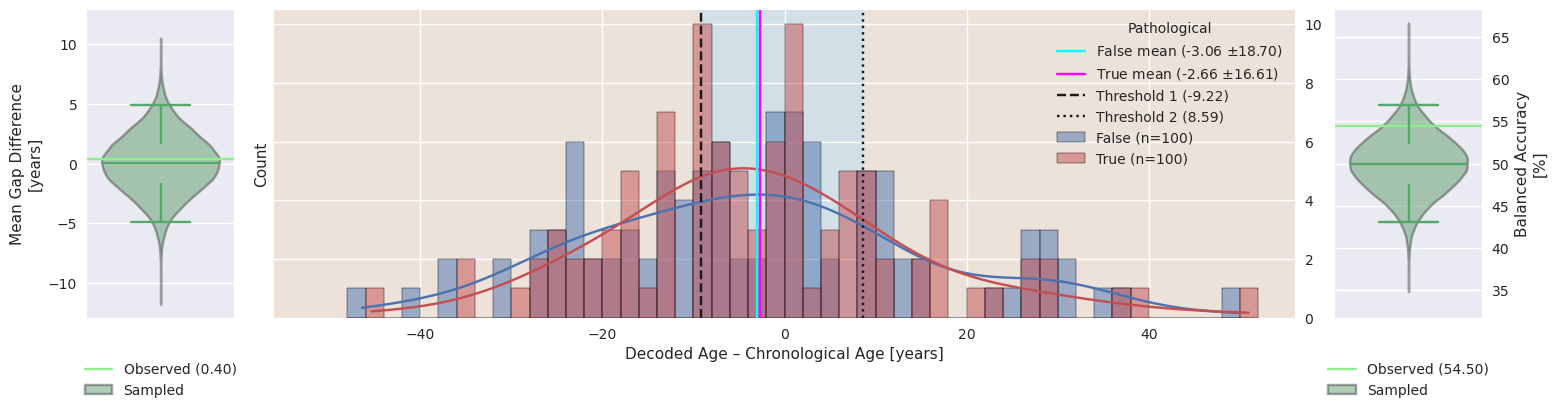

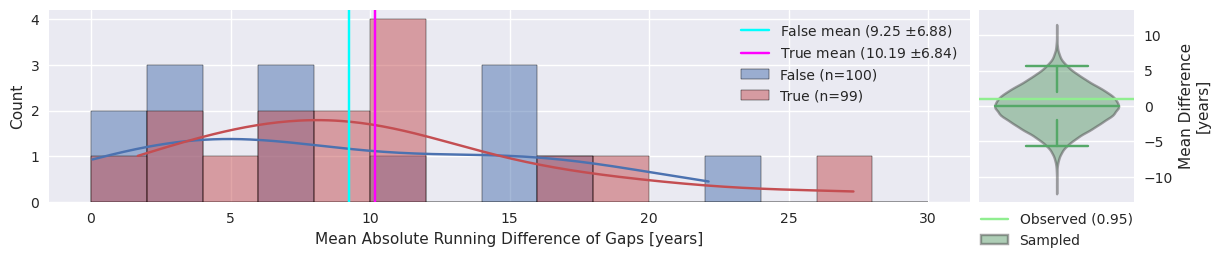

In [93]:
for ds_name in all_subj_preds.keys():
    rec_preds = all_rec_preds[ds_name]
    subj_preds = all_subj_preds[ds_name]
    print(ds_name)
    if ds_name.startswith('transition'):
        """
        ax = plot_age_gap_hist_and_permutation_test(gs_10_subj, bin_size, n_repetitions)
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_age_gap_histogram')
        ax = plot_age_gap_hist_with_thresh_and_permutation_test(
            gs_10_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_age_gap_proxy')
        """
        ax = plot_permutation_test_and_age_gap_hist_with_thresh_and_permutation_test(
            gs_10_subj,
            t_low,
            t_high,
            bin_size,
            n_repetitions,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_age_gap_proxy')
        ax = plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
            mean_abs_running_diff_of_mean_corrected_gaps(gs_10), 
            n_repetitions,
            bin_width,
        )
        if save_figures:
            save_fig(ax.get_figure(), '/home/jovyan/figures/', f'longitudinal_pnp_running_age_gap')

In [83]:
# TODO: compute same day variance

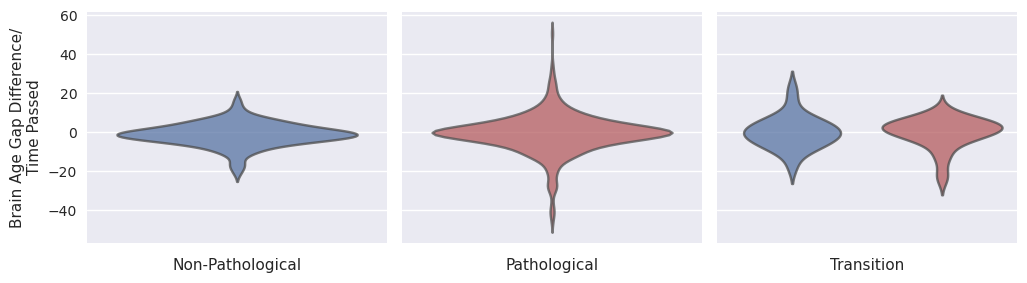

In [193]:
# compute running gap and devide by passed time (if zero, divide by one?)
fig, ax_arr = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ds_i, ds_name in enumerate(all_rec_preds.keys()):
    m = []
    for s, g in all_rec_preds[ds_name].groupby(['subject', 'pathological'], as_index=False):
        h = (g.y_pred_deconfounded_quadratic - g.y_true).diff()[1:]
        b = g.y_true.diff()[1:]
        # TODO: how to handle recordings that were performed on the same day?
        # division by zero
        # TODO: add handling of pathology status in LT
        #b[b==0] += 1
        h = h[b!=0]
        b = b[b!=0]
        m.append([s[0], s[1], (h/b).mean()])
    m = pd.DataFrame(m, columns=['subject', 'pathological', 'gap ratio'])
    ax = sns.violinplot(
        data=m, y='gap ratio', x='pathological' if ds_name == 'transition' else None, 
        palette=['r'] if ds_name == 'pathological' else ['b', 'r'],
        inner=None,
        ax=ax_arr[ds_i],
    )
    """
    if ds_name in ['non_pathological', 'pathological']:
        c = 'b' if ds_name == 'non_pathological' else 'r'
        sns.boxplot(
            y=m['gap ratio'], ax=ax,
            showfliers=False, showbox=False, whis=[25,75],
            **{
                'boxprops':{'facecolor':'none', 'edgecolor':c},
                'medianprops':{'color':c},
                'whiskerprops':{'color':c},
                'capprops':{'color':c}
            },
        )
    """
    ax.set_ylabel('Brain Age Gap Difference/\nTime Passed' if ds_name == 'non_pathological' else '')
    ax.set_xticklabels([])
    if ds_name == 'transition':
        ds_name = 'Transition'
    elif ds_name == 'pathological':
        ds_name = 'Pathological'
    elif ds_name == 'non_pathological':
        ds_name = 'Non-Pathological'
    ax.set_xlabel(ds_name)
    
    # set violin alpha = .5
    # https://github.com/mwaskom/seaborn/issues/622
    from matplotlib.collections import PolyCollection
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_alpha(.75)
    
plt.subplots_adjust(wspace=.05)

/opt/conda/envs/job-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/job-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/job-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/job-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/job-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/job-env/lib/python3.9/site-package

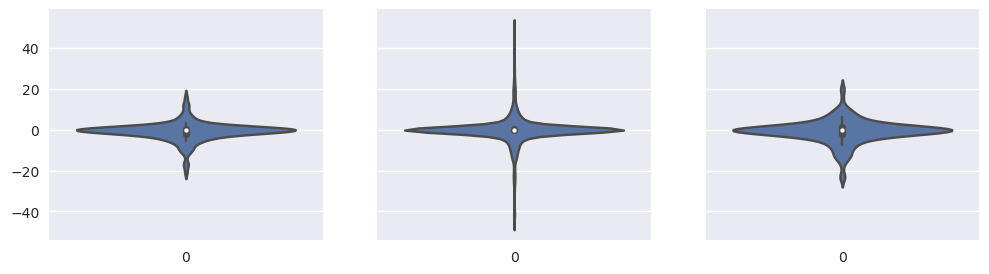

In [174]:
ms = {}
fig, ax_arr = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ds_i, ds_name in enumerate(all_rec_preds.keys()):
    ms[ds_name] = []
    for s, g in all_rec_preds[ds_name].groupby('subject'):
        m, b = np.polyfit(g.y_true, g.y_pred - g.y_true, 1)
        ms[ds_name].append(m)
    ax = sns.violinplot(ms[ds_name], ax=ax_arr[ds_i])

In [102]:
# 40   -   50
+3   -   +3
43   -   52

-9

In [234]:
3/3  -   2/3

0.33333333333333337

In [177]:
# compute running gap and subtract passed time
for s, g in all_rec_preds['non_pathological'].groupby('subject'):
    h = (g.y_pred_deconfounded_quadratic - g.y_true).diff()[1:]
    print(s)
    print(h)
    b = g.y_true.diff()[1:]
    print(h-b)
    print()


18.0
1    10.028133
dtype: float64
1    10.028114
dtype: float64

59.0
3   -8.0072
dtype: float64
3   -1.60144
dtype: float64

169.0
5   -8.109707
dtype: float64
5   -8.109712
dtype: float64

337.0
7   -12.031366
8   -18.241655
dtype: float64
7   -3.007842
8   -6.080551
dtype: float64

377.0
10    6.930066
dtype: float64
10    2.31002
dtype: float64

390.0
12    3.061563
dtype: float64
12    3.061557
dtype: float64

429.0
14   -18.577583
dtype: float64
14   -inf
dtype: float64

515.0
16    16.936576
17    -9.548558
dtype: float64
16    16.936566
17    -4.774279
dtype: float64

566.0
19   -8.655982
dtype: float64
19   -8.655987
dtype: float64

605.0
21    2.267847
22    1.715613
23    1.742624
dtype: float64
21    2.267849
22    0.857806
23         inf
dtype: float64

623.0
25   -5.989176
dtype: float64
25   -1.197835
dtype: float64

657.0
27   -15.787561
dtype: float64
27   -5.262519
dtype: float64

747.0
29   -8.288769
dtype: float64
29   -0.753525
dtype: float64

783.0
31     7.43878

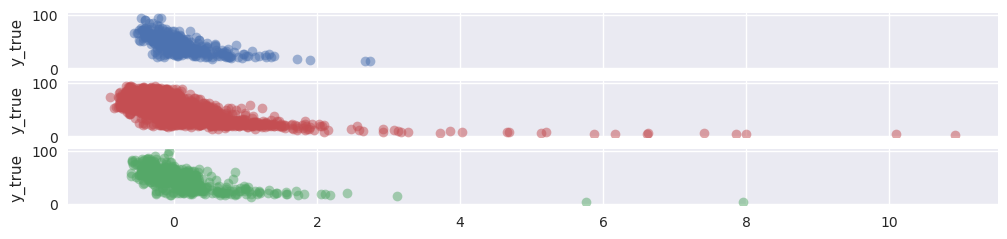

In [137]:
cs = {'non_pathological': 'b', 'pathological': 'r', 'transition': 'g'}
fig, ax_arr = plt.subplots(3, 1, figsize=(12,2.5), sharex=True, sharey=True)
for ds_i, (ds_name, df) in enumerate(all_rec_preds.items()):
    ax = ax_arr[ds_i]
    sns.regplot(
        y=all_rec_preds[ds_name]['y_true'], 
        x=(all_rec_preds[ds_name]['y_pred_deconfounded_quadratic']-all_rec_preds[ds_name]['y_true'])/all_rec_preds[ds_name]['y_true'],
        scatter_kws={'alpha': .5},
        color=cs[ds_name],
        ax=ax,
        scatter=True,
        fit_reg=False,
    )

In [99]:
# TODO: understand what is n_subjects and why there is so many less data points in running diff plot. is it due to diff?
# TODO: find some better way to analyze this

In [120]:
def mean_abs_running_diff_of_mean_corrected_gaps(rec_preds):
    # group all preds by subject and pathology status
    # subtract mean of pred and label
    # compute the gaps
    # then compute the diffs
    # take the absolute value
    # and average
    # TODO: does not take into account different seeds / runs?!
    d = []
    for i, ((subject, pathological), g) in enumerate(rec_preds.groupby(['subject', 'pathological'])):
        #g['y_true'] -= g['y_true'].mean()  # does not make a difference
        #g['y_pred'] -= g['y_pred'].mean()  # does not make a difference
        mean = (g.y_pred - g.y_true).diff().abs().mean()
        d.append({
            'mean': mean,  # TODO: diff could be a problem in y_pred 
            'subject': subject,
            'pathological': pathological,
        })
    d = pd.DataFrame(d)
    return d

p=4.30E-01


<AxesSubplot: xlabel='Mean Absolute Running Difference of Gaps [years]', ylabel='Count'>

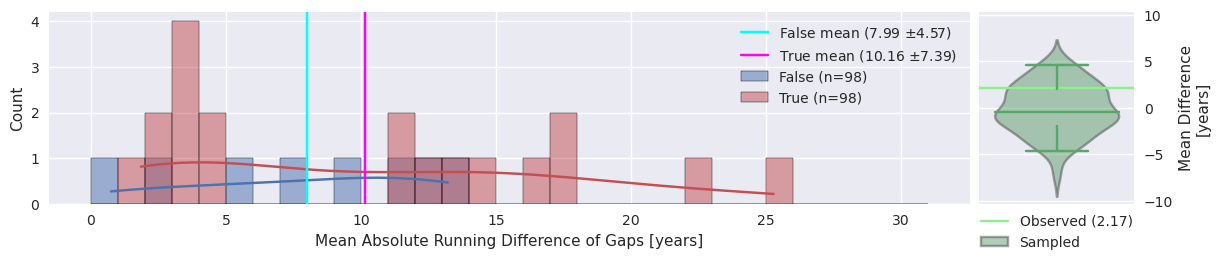

In [121]:
plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
    mean_abs_running_diff_of_mean_corrected_gaps(gs_01),#.fillna(0),
    100,
    1,
)

In [122]:
for s, g in gs_01.groupby('subject'):
    break

In [123]:
g

,subset,index,y_true,y_pred,year,month,day,subject,session,segment,...,pathological,train,seed,valid_set_i,date_age,report_age,duration,y_pred_confounded,y_pred_deconfounded_linear,y_pred_deconfounded_quadratic
17,longitudinal_transition,72,64.000001,47.272336,2003.0,4.0,2.0,94.0,1.0,0.0,...,1.0,1.0,20230216.0,0.0,64.0,63.0,1502.0,46.829682,48.459344,47.272336
18,longitudinal_transition,73,66.999999,46.955583,2006.0,7.0,31.0,94.0,2.0,0.0,...,0.0,1.0,20230216.0,0.0,67.0,66.0,1217.0,46.596176,48.141052,46.955583
19,longitudinal_transition,75,67.999998,40.354340,2007.0,3.0,28.0,94.0,3.0,2.0,...,0.0,1.0,20230216.0,0.0,68.0,67.0,3174.0,41.646012,41.393474,40.354340


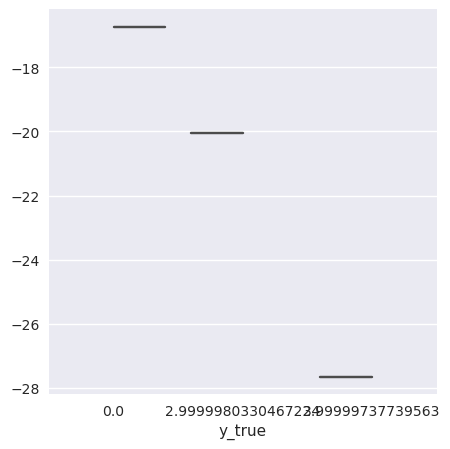

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
for s, g in gs_01.groupby('subject'):
    sns.violinplot(
        x=(g.y_true - g.y_true.iloc[0]), 
        y=(g.y_pred - g.y_true.iloc[0]) - (g.y_true - g.y_true.iloc[0]), 
        hue=g.pathological, 
        palette={0: 'b', 1: 'r'},
        ax=ax,
    )
    break
ax.legend([])

In [125]:
ax1 = 'y_true'
ax2 = 'y_pred'
ax3 = 'pathological'

Text(0.5, 0, 'pathological')

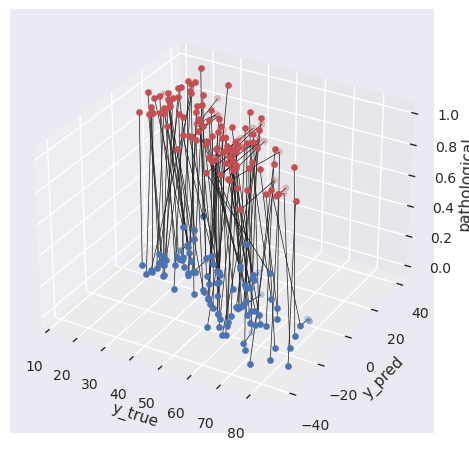

In [126]:
ax = plt.axes(projection='3d')
for s, g in gs_01.groupby('subject'):
    g=g.sort_values('y_true')
    ax.plot3D(g[ax1], g[ax2]-g[ax1], g[ax3], c='k', linewidth=.5)
    ax.scatter3D(
        g[g.pathological==0][ax1], 
        g[g.pathological==0][ax2]-g[g.pathological==0][ax1], 
        g[g.pathological==0][ax3],
        c='b',
    )
    ax.scatter3D(
        g[g.pathological==1][ax1], 
        g[g.pathological==1][ax2]-g[g.pathological==1][ax1], 
        g[g.pathological==1][ax3],
        c='r',
    )
ax.set_xlabel(ax1)
ax.set_ylabel(ax2)
ax.set_zlabel(ax3)

# plot recording durations and intervals

In [37]:
min_mins = 2
clean_age = False

In [38]:
all_rec_preds = []
for ds_name in ['non_pathological', 'pathological', 'transition']:
    all_rec_preds.append(get_longitudinal_preds(ds_name, min_mins, clean_age))
    if ds_name == 'non_pathological':
        name = 'Non-Pathological' 
    elif ds_name == 'pathological':
        name = 'Pathological'
    else:
        name = 'Transition'
    all_rec_predſ[-1]['Longitudinal'] = name
all_rec_preds = pd.concat(all_rec_preds)

In [40]:
all_rec_preds.shape

(128815, 25)

In [41]:
(all_rec_preds.n_samples / all_rec_preds.sfreq).max()

86394.0

In [42]:
76738/60

1278.9666666666667

In [43]:
all_rec_preds.subset.unique()

array(['longitudinal_non_pathological', 'longitudinal_pathological',
       'longitudinal_transition'], dtype=object)

In [44]:
all_rec_preds.iloc[all_rec_preds.duration.argmax()]

y_true                                                       14.0
y_pred                                                  38.769389
path            /home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...
version                                                    v1.1.0
year                                                         2015
month                                                           7
day                                                             1
subject                                                     13113
session                                                         3
segment                                                         0
reference                                                      ar
sfreq                                                       256.0
n_samples                                                22116864
age                                                            14
gender                                                          M
report    

In [51]:
def plot_recording_durations(all_rec_preds_, tmax=30, stepsize=1, ax=None):
    all_rec_preds = all_rec_preds_.copy() 
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,3))
    all_rec_preds.duration.clip(upper=tmax*60, inplace=True)
    bins = [t*60 for t in range(2, tmax+1, stepsize)]
    ax = sns.histplot(
        data=all_rec_preds,
        x='duration',
        hue='Longitudinal',
        palette=['b', 'r', 'g'],
        bins=bins,
        multiple='stack',
        alpha=.5,
    )
    ax.set_xlabel('Duration [min]')
    tick_bins = [t for t in [2, 5, 10, 15, 20, 25, 30]]
    ax.set_xticks([t*60 for t in tick_bins]);
    ax.set_xticklabels([f'{t}' for t in tick_bins]);
    return ax

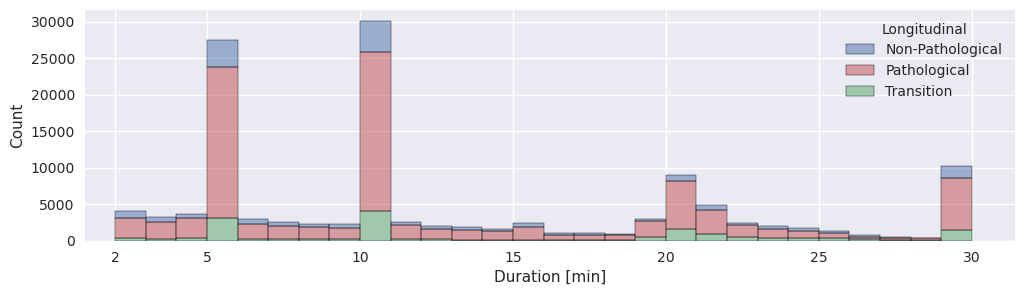

In [53]:
ax = plot_recording_durations(all_rec_preds)
ax.set_xlim((min_mins-1)*60)
#save_fig(ax.get_figure(), '/home/jovyan/figures/', 'Longitudinal_recording_durations')

In [153]:
from datetime import datetime

In [154]:
from decode_tueg import plot_n_recs_per_subject_and_rec_intervals

In [155]:
all_rec_preds.shape

(17970, 27)

In [156]:
# information is there from 5 repetitions of fe. only choose one
all_rec_preds = all_rec_preds[all_rec_preds.seed==20230214]

In [165]:
all_rec_preds.shape

(3594, 27)

In [158]:
n_recs_per_subject = all_rec_preds.groupby(['Longitudinal', 'subject'], as_index=False).size()

In [166]:
(n_recs_per_subject.size > 2).all()

True

In [167]:
# sort the dataframe for correct computation of day diffs
all_rec_preds = all_rec_preds.sort_values(['Longitudinal', 'year', 'month', 'day'])

In [168]:
day_diffs = []
for (dataset, subj), group in all_rec_preds.groupby(['Longitudinal','subject']):
    dates = [datetime(y, m, d) for i, (y, m, d) in group[['year', 'month', 'day']].iterrows()]
    for i in range(1, len(dates)):
        day_diffs.append((dataset, (dates[i] - dates[i-1]).days, subj))
day_diffs = pd.DataFrame(day_diffs, columns=['Dataset', 'Interval [days]', 'Subject'])

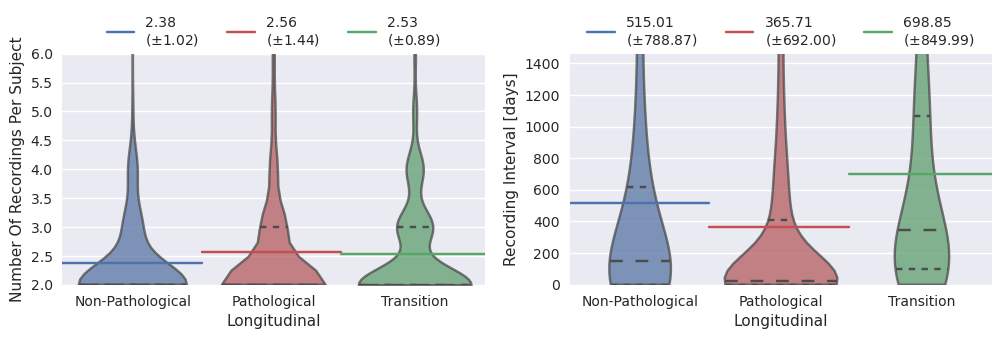

In [178]:
ax_arr = plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)
save_fig(ax_arr[0].get_figure(), '/home/jovyan/figures/', 'Longitudinal_recs_per_subject_and_durations')

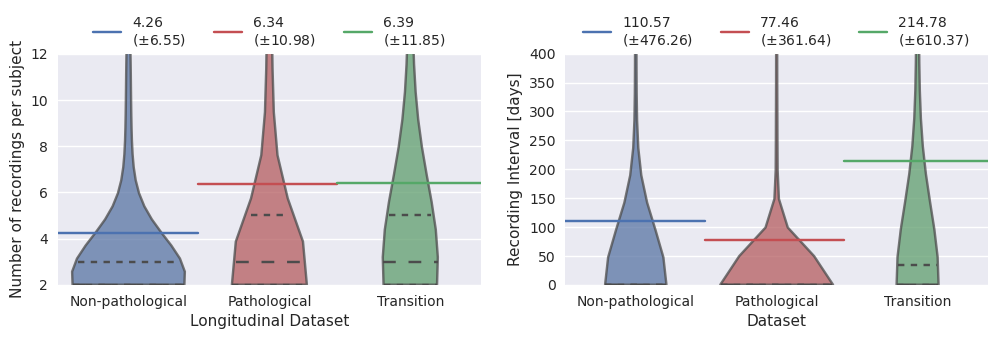

In [471]:
ax_arr[0].set_ylim(2,12)
ax_arr[1].set_ylim(0,400)
ax_arr[0].get_figure()

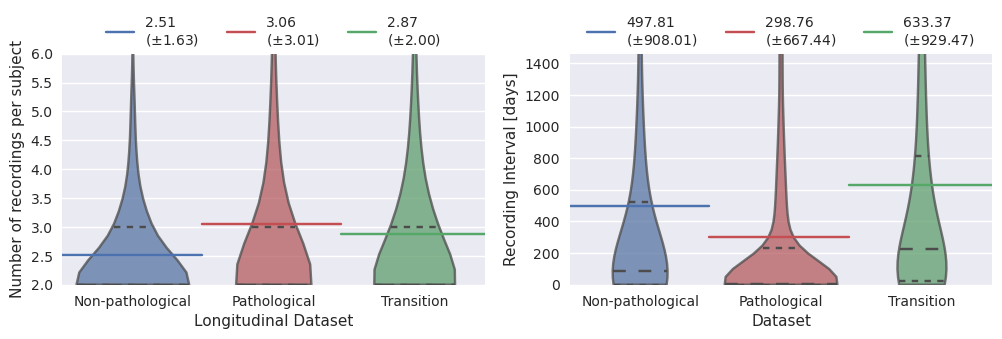

In [452]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

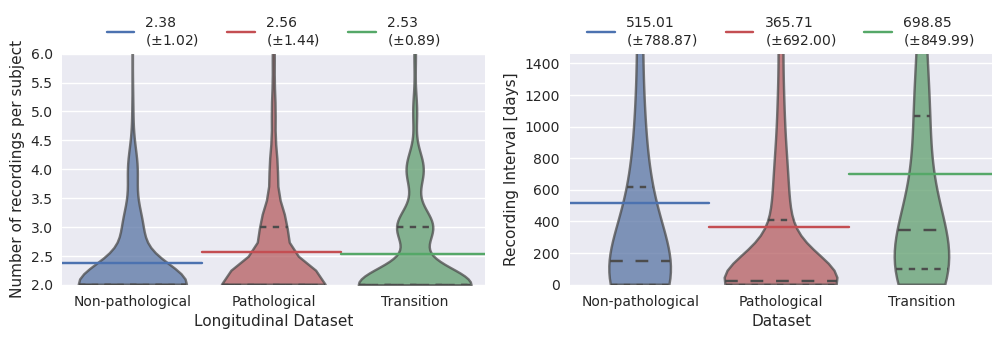

In [431]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

# look at interesting cases, e.g. very large EEG brain age gap

In [666]:
# TODO: absolute biggest gap or biggest gap on averge?
def find_preds_of_subj_with_biggest_gap(all_rec_preds, ds_name, gap_sign, top):
    if ds_name is not None:
        long_rec_preds = all_rec_preds[all_rec_preds['Longitudinal']==ds_name]
    else:
        long_rec_preds = all_rec_preds
    all_rec_preds['gap'] = all_rec_preds.y_pred - all_rec_preds.y_true
    yes = False
    if yes:
        all_rec_preds['gap'] = all_rec_preds.gap.abs()
    long_subj_preds = long_rec_preds.groupby(
        ['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    #gaps = long_subj_preds.y_pred - long_subj_preds.y_true
    gaps = long_subj_preds.gap
    for idx, gap in gaps.sort_values(ascending=gap_sign=='-').head(top).tail(1).items():
        _
    subject = long_subj_preds.iloc[idx].subject
    for seed, group in long_rec_preds[long_rec_preds.subject==subject].groupby('seed'):
        #if seed == 20230216:
            break
    return gap, group

# look at most precise predictions

In [677]:
tmp = all_rec_preds.copy()

In [678]:
tmp['gap'] = (tmp.y_pred-tmp.y_true).abs()

In [699]:
name = 'longitudinal_non_pathological'

In [700]:
tmp[tmp.subset==name].groupby(['subject'], as_index=False).sum(numeric_only=True).gap.min()

1.739314168691628

In [701]:
tmp[tmp.subset==name].groupby(['subset', 'subject'], as_index=False).sum(numeric_only=True).gap.argmin()

45

In [702]:
tmp[tmp.subset==name].groupby(['subset', 'subject'], as_index=False).sum(numeric_only=True).iloc[45].subject

2298

In [703]:
all_rec_preds[all_rec_preds.subject==2298]

,y_true,y_pred,path,version,year,month,day,subject,session,segment,...,train,IMPRESSION,subset,seed,valid_set_i,date_age,report_age,duration,Longitudinal,gap
index,,,,,,,,,,,,,,,,,,,,,
505,35.999999,36.352202,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2005,2,14,2298,1,1,...,True,IMPRESSION: Normal EEG in wakefulness and drow...,longitudinal_non_pathological,20230214,0,36.0,35.0,1453.0,Non-pathological,0.352203
506,39.000000,37.612888,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2008,5,13,2298,2,0,...,True,IMPRESSION: EEG within normal limits.,longitudinal_non_pathological,20230214,0,39.0,38.0,1387.0,Non-pathological,-1.387112


In [704]:
all_rec_preds[all_rec_preds.subject==2298].pathological

index
505    0
506    0
Name: pathological, dtype: int64

In [705]:
for r in all_rec_preds[all_rec_preds.subject==2298].report:
    print(r)

CLINICAL HISTORY: This is a 35-year-old woman with seizures in childhood, in remission since age 7, now with new onset seizures in 2003.  Last seizure was three weeks ago with a frequency  of once a  month.    Generalized tonic-clonic seizures  with loss of  consciousness, postictal confusion, and sleepiness.   She also reports a few seizures during sleep, but doesn't know when. Patient diagnosed with depression and HIV in June 2004.
MEDICATIONS:  Erythromycin, Effexor, Buspirone, Pravachol, and Carbamazepine. INTRODUCTION: Digital video EEG is performed in the lab using standard 10-20 system of
electrode placement with one channel of EKG. Hyperventilation and photic stimulation were performed. This is an awake and asleep record.
DESCRIPTION OF THE  RECORD:  In wakefulness, the background EEG is well organized and symmetric with an 11 Hz posterior dominant rhythm with low voltage, frontotemporal beta activity.   Patient had a normal variant of 14 and 6 Hz positive spikes.     Hypervent

In [674]:
ds_name = 'Non-pathological'
sign = '-'  # +,-
top = 1  # integer

In [675]:
gap, group = find_preds_of_subj_with_biggest_gap(
    all_rec_preds, 
    ds_name, 
    sign, 
    top,
)

In [676]:
gap

-36.34204995135466

In [636]:
cols = [
    'y_true', 'y_pred', 'year', 'subject', 'pathological', 'duration', 'Longitudinal', 
    'report_age', 'date_age', 'age', 'session', 'segment']
group[cols]

,y_true,y_pred,year,subject,pathological,duration,Longitudinal,report_age,date_age,age,session,segment
index,,,,,,,,,,,,
250,66.999999,28.980930,2004,1218,0,1139.0,Non-pathological,67.0,67.0,67,2,0
253,66.999999,31.425873,2004,1218,0,1500.0,Non-pathological,67.0,67.0,67,2,5
254,66.999999,31.567043,2004,1218,0,1500.0,Non-pathological,67.0,67.0,67,2,7


In [637]:
# TODO: -1 y_true super weird. check what is happening! not super weird. was unclean age rec

In [638]:
for index, (y,m,d,r) in group[['year', 'month', 'day', 'report']].iterrows():
    print(y,m,d)
    print(r.strip())
    print()

2004 9 22
CLINICAL HISTORY: This is a 67-year-old male with hypertension, diabetes, prostate cancer, and right carotid stenosis.
MEDICATIONS: Diovan, Metformin, aspirin, Plavix, and Glipizide.
INTRODUCTION: Digital video EEG is performed in the lab using standard 10-20 system of electrode placement with one channel of EKG. Photic stimulation was performed.  This is an awake and asleep record.
DESCRIPTION OF THE RECORD: In wakefulness, the background EEG is well organized, low voltage, with a 9.5 Hz, 20 uV posterior dominant rhythm.  The EEG is symmetric and reactive to eye opening.  Photic stimulation elicits minimal driving.
HR:  78 BPM.
IMPRESSION: Normal EEG in wakefulness.
CLINICAL CORRELATION: No focal or epileptiform features were identified in this record.

2004 9 22
CLINICAL HISTORY: This is a 67-year-old male with hypertension, diabetes, prostate cancer, and right carotid stenosis.
MEDICATIONS: Diovan, Metformin, aspirin, Plavix, and Glipizide.
INTRODUCTION: Digital video EEG 